In [1]:

import json
import torch
from torchvision import models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import torch.nn.functional as F
# dev for scaling
import numpy as np

import torchvision.transforms as T
from PIL import Image

from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

def refine_paths(experiment,args, additional_embedding=None):



    path_list = experiment['train']

    def load_image(filename, crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, aligned=False) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())


    shuffled_final = np.array(featuremaps).squeeze()
    
    def expand_to_three_channels(tensor):
        return tensor.repeat(3, 1, 1)  # Repeat the single channel three times

    isolation_outliers = []
    lof_outliers = []

    for i in range(shuffled_final.shape[1]):
        feature_maps = shuffled_final[:, i, :, :]
        
        if additional_embedding:
            # Expanding feature maps to three channels
            expanded_feature_maps = torch.stack([expand_to_three_channels(fm) for fm in feature_maps])
            images=[transformation_chain(image) for image in expanded_feature_maps]
            images=torch.stack(images)
            embeddings = model(images).last_hidden_state[:, 0].cpu()
            feature_maps = F.normalize(embeddings, p=2, dim=1)
            
        
        else:
            pass
        
        
        flattened_feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(flattened_feature_maps)

        clf_isolation = IsolationForest(contamination=args.assumed_contamination_rate)
        outliers_isolation = clf_isolation.fit_predict(features_scaled)
        isolation_outliers.append(outliers_isolation)
        # iso_scores = -clf_isolation.decision_function(features_scaled)
        # isolation_outliers.append(iso_scores)
        
        clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)


        outliers_lof = clf_lof.fit_predict(features_scaled)
        lof_scores = -clf_lof.negative_outlier_factor_
        lof_outliers.append(outliers_lof)
        #of_outliers.append(lof_scores)

    isolation_outliers = np.array(isolation_outliers)
    lof_outliers = np.array(lof_outliers)

    isolation_column_sums = isolation_outliers.sum(axis=0)
    lof_column_sums = lof_outliers.sum(axis=0)


    remove_inds=np.array(lof_column_sums).argsort()[:int(args.assumed_contamination_rate * len(lof_column_sums))]
    selected_paths = [path_list[i] for i in remove_inds]
    refined_paths= [path for path in path_list if path not in selected_paths]

    experiment['isoforest_scores'] = isolation_column_sums.tolist()
    experiment['lof_scores'] = lof_column_sums.tolist()
    experiment['lof_refined_paths'] = refined_paths

    return experiment

    # with open(experiment_path, 'w') as file:
    #     json.dump(experiment, file)
        


def precision_recall(distance_metric: list, groundtruth: list, quantiles: float = 0.001, thresh_larger: bool = False) -> tuple:
    """
    Calculates precision and recall for a given distance metric.
    params: 
        distance_metric: list of distance metric values
        groundtruth: list of groundtruth labels
        quantiles: number of quantiles to calculate precision and recall
        thresh_larger: if True, then the larger the distance_metric the more likely it's a normal sample
    returns: 
        tuple of precision and recall
    """
    quantile_list = np.arange(0, 1, quantiles)
    precision, recall = [], []
    for quantile in quantile_list:
        thresh = np.quantile(distance_metric, quantile)
        predict = np.zeros_like(distance_metric)  # predictions are all normals
        if thresh_larger:
            idxs = np.where(np.array(distance_metric) <= thresh)[0]  # all anomalies
        else:
            idxs = np.where(np.array(distance_metric) >= thresh)[0]  # all anomalies

        predict[idxs] = 1
        tn, fp, fn, tp = confusion_matrix(groundtruth, predict).ravel()

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

def precision_recall(distance_metric: list, groundtruth: list, quantiles: float = 0.001, thresh_larger: bool = False) -> tuple:
    """
    Calculates precision and recall for a given distance metric.
    params: 
        distance_metric: list of distance metric values
        groundtruth: list of groundtruth labels
        quantiles: number of quantiles to calculate precision and recall
        thresh_larger: if True, then the larger the distance_metric the more likely it's a normal sample
    returns: 
        tuple of precision and recall
    """
    quantile_list = np.arange(0, 1, quantiles)
    precision, recall = [], []
    for quantile in quantile_list:
        thresh = np.quantile(distance_metric, quantile)
        predict = np.zeros_like(distance_metric)  # predictions are all normals
        if thresh_larger:
            idxs = np.where(np.array(distance_metric) <= thresh)[0]  # all anomalies
        else:
            idxs = np.where(np.array(distance_metric) >= thresh)[0]  # all anomalies

        predict[idxs] = 1
        tn, fp, fn, tp = confusion_matrix(groundtruth, predict).ravel()

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

def PR_ROC_runs(data_input: dict, category: str):
    plt.figure(figsize=(20, 8))  # Increased figure size for better visibility
    plt.suptitle(f'{category}', y=1.02, fontsize=16)
    
    class_names = []
    data = {}
    
    # Scale all scores in data
    for key in data_input.keys():
        if key not in ['paths', 'gt_labels']:
            # scale the scores from the own approach
            if key in  ['own; ISO', 'own; LOF']:
    
                class_names.append(key)
                scaled_runs = []
                runs = data_input[key]
                for run in runs:
                    if not isinstance(run, np.ndarray):
                        run = np.array(run)
                        
                    scaler = MinMaxScaler()
                    scores_scaled = scaler.fit_transform(run.reshape(-1, 1)).flatten()
                    scaled_runs.append(1 - scores_scaled)
                data[key] = np.array(scaled_runs)
            else:
                class_names.append(key)
                data[key] = np.array(data_input[key])    
                
            
    print(class_names)
            

    # colors = [
    #     'skyblue', 'blue',
    #     'lightcoral', 'red',
    #     'lightgray', 'gray',        
    #     'lightgreen', 'green',
    #     'peachpuff', 'orange',
    #     'lightyellow', 'yellow',
    #     'lightpink', 'deeppink',
    #     'thistle', 'purple',
    #     'palegreen', 'limegreen',
    #     'powderblue', 'teal',
    #     'lightsteelblue', 'navy'
    # ]
    colors = ['skyblue', 'blue','lightcoral', 'red','purple', 'thistle','lightgreen', 'green', 'navy','lightgray', 'gray','deeppink','peachpuff', 'orange','lightolive', 'darkolivegreen','palegreen', 'limegreen','powderblue', 'teal','lightsteelblue', 'navy']

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    for class_index, class_name in enumerate(class_names):
        print(class_name)
        scores_list = data[class_name]
        
        # Calculate precision-recall values for each run
        precision_runs = []  # List to store precision values for each run
        recall_runs = [] 
        
        for scores, gt in zip(scores_list, data_input['gt_labels']):
            
            precision, recall = precision_recall(scores, gt)
            precision_runs.append(precision)
            recall_runs.append(recall)

        precision_mean = np.mean(precision_runs, axis=0)
        recall_mean = np.mean(recall_runs, axis=0)
        
        precision_max = np.max(precision_runs, axis=0)
        precision_min = np.min(precision_runs, axis=0)
        pr_auc = auc(recall_mean, precision_mean)

        plt.fill_between(recall_mean, precision_min, precision_max, alpha=0.1, color=colors[class_index])
        plt.plot(recall_mean, precision_mean, label=f'{class_name} AUC {pr_auc:.3f}', color=colors[class_index])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Legends below the plot

    # ROC Curve Subplot
    plt.subplot(1, 2, 2)
    for class_index, class_name in enumerate(class_names):
        scores_list = data[class_name]
        
        # Calculate ROC values for each run
        fprs = []
        tprs = []
        roc_aucs = []

        for scores, gt in zip(scores_list, data_input['gt_labels']):
            fpr, tpr, _ = roc_curve(gt, scores)
            #plt.plot(fpr, tpr, color='gray', alpha=0.1)
            
            fprs.append(np.interp(np.linspace(0, 1, 1000), fpr, tpr))  # Interpolating to have the same fpr points
            roc_aucs.append(auc(fpr, tpr))

        fprs = np.array(fprs)

        # Calculate max, min, and median tpr at each fpr point
        tpr_max = np.max(fprs, axis=0)
        tpr_min = np.min(fprs, axis=0)
        tpr_median = np.median(fprs, axis=0)
        fpr_points = np.linspace(0, 1, 1000)
        
        roc_auc = np.mean(roc_aucs)
        plt.fill_between(fpr_points, tpr_min, tpr_max, alpha=0.1, color=colors[class_index])
        plt.plot(fpr_points, tpr_median, label=f'{class_name} AUC: {roc_auc:.3f}', color=colors[class_index])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Legends below the plot

    # Adjust layout to add space between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust the space between subplots

    plt.show()
    
#original

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

def metrics_and_plots(labels, scores1, scores2, scores3, category):
    scores_list = [scores1, scores2, scores3]
    colors = ['blue', 'green', 'red']
    labels_scores = ['Iso-Forest', 'LOF', 'Ensemble']

    plt.figure(figsize=(24, 6))
    plt.suptitle(f'{category}', y=1.02, fontsize=16) 

    # Plot Precision-Recall curves
    plt.subplot(1, 3, 1)
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        precision, recall, _ = precision_recall_curve(labels, 1 - scores_scaled)
        avg_precision = average_precision_score(labels, 1 - scores_scaled)
        plt.plot(recall, precision, marker='.', color=color, label=f'{label} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # Plot ROC curves
    plt.subplot(1, 3, 2)
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        fpr, tpr, _ = roc_curve(labels, 1 - scores_scaled)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, marker='.', color=color, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Plot FNR vs Threshold
    plt.subplot(1, 3, 3)
    
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        
        indsort=scores_scaled.argsort()
        sorted=scores_scaled[indsort]
        sorted_labs=np.array(labels)[indsort]

        fnr_values = []
        fpr_values = []

        # Calculate FNR for each quantile from 1 to 100
        for q in range(0, 102,2):
            threshold = np.percentile(sorted, q)
            predictions = (sorted <= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(1-sorted_labs, 1-predictions).ravel()
            # Calculate FNR
            fnr = fn / (tn+fn) if (tn+fn)> 0 else 0
            fnr_values.append(fnr)
            
            fpr = fp / (tn+fp) if (tn+fp)> 0 else 0
            fpr_values.append(fpr)

        # plt.plot(range(0, 102,2), fnr_values, marker='o',color=color)
        plt.plot(range(0, 102,2), fpr_values, marker='o',color=color)
    plt.title('False Negative Ratio (FNR) by Percentile')
    plt.xlabel('Percentile')
    plt.ylabel('False Negative Ratio (FNR)')
    plt.grid(True)
    plt.show()
        

    # Plot histograms of scaled scores
    plt.figure(figsize=(18, 6))
    plt.suptitle(f'{category}', y=1.02, fontsize=16) 
    for i, (scores, color, label) in enumerate(zip(scores_list, colors, labels_scores)):
        plt.subplot(1, 3, i+1)
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        scores_scaled_0 = scores_scaled[labels == 0]
        scores_scaled_1 = scores_scaled[labels == 1]
        plt.hist(scores_scaled_0, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Normals')
        plt.hist(scores_scaled_1, bins=30, color='green', edgecolor='black', alpha=0.7, label='Anomalies')
        plt.title(f'Distribution of {label}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Creating a bar plot for Scores 1, Scores 2, and Scores 3
    plt.figure(figsize=(30, 6))
    x = np.arange(len(scores1))
    width = 0.2

    plt.bar(x - width, scores1, width, label='Iso-Forest', color='blue')
    plt.bar(x, scores2, width, label='LOF', color='green')
    # plt.bar(x + width, scores3, width, label='Ensemble', color='red')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Plot of Scores')
    plt.legend()
    plt.show()
    
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img


def feature_extraction(experiment,args):



    path_list = experiment['train']

    def load_image(filename, crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, aligned=False) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())


    shuffled_final = np.array(featuremaps).squeeze()
    return shuffled_final


import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def PR_ROC__stats(data_input: dict, category: str):
    class_names = []
    data = {}
    
    # Scale all scores in data
    for key in data_input.keys():
        if key not in ['paths', 'gt_labels']:
            # Scale the scores from the own approach
            if key in ['own; ISO', 'own; LOF']:
                class_names.append(key)
                scaled_runs = []
                runs = data_input[key]
                for run in runs:
                    if not isinstance(run, np.ndarray):
                        run = np.array(run)
                    
                    scaler = MinMaxScaler()
                    scores_scaled = scaler.fit_transform(run.reshape(-1, 1)).flatten()
                    scaled_runs.append(1 - scores_scaled)
                data[key] = np.array(scaled_runs)
            else:
                class_names.append(key)
                data[key] = np.array(data_input[key])
    
    print(class_names)
    
    resdict = {'method': [],  'run': [], 'metric':[],'score':[], 'category': []}
    
    for class_index, class_name in enumerate(class_names):
        print(class_name)
        scores_list = data[class_name]
        
        for run, (scores, gt) in enumerate(zip(scores_list, data_input['gt_labels'])):
            precision, recall, _ = precision_recall_curve(gt, scores)
            pr_auc = auc(recall, precision)
            
            resdict['method'].append(class_name)
            resdict['metric'].append('PRAUC')
            resdict['run'].append(run)
            resdict['score'].append(pr_auc)
            resdict['category'].append(category)
            
            fpr, tpr, _ = roc_curve(gt, scores)
            roc_auc = auc(fpr, tpr)
            
            resdict['method'].append(class_name)
            resdict['metric'].append('ROCAUC')
            resdict['run'].append(run)
            resdict['score'].append(roc_auc)
            resdict['category'].append(category)
    
    return resdict

# Example usage:
# result = PR_ROC__stats(input_, category="leather")


2024-07-27 11:13:42.965641: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 11:13:42.989891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 11:13:43.378960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.

In [36]:
def get_fmaps(path_list,angle):

    def load_image(filename, angle=0,crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.rotate(img, angle, fill=(0,))
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, angle,aligned=True) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())


    shuffled_final = np.array(featuremaps).squeeze()
    return shuffled_final

class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "grid"
args = TrainOptions(category)

angle=[0,90,180,270]
shuffled_list=[]
for i , angle in enumerate(angle):
    print(f'Run {i}{angle}')
    path=f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{1}-{category}/experiment_paths.json' 

    with open(path, 'r') as file:
        experiment = json.load(file)

    shuffled_final =get_fmaps(experiment['train'],angle=angle)
    shuffled_list.append(shuffled_final)
    
labels=[0 if 'good' in path else 1 for path in experiment['train']]
  
    

Run 00
Run 190
Run 2180
Run 3270


In [33]:
shuffled_final.shape

(289, 448, 64, 64)

In [58]:
import torch
import torch.nn.functional as F
from transformers import ViTModel, ViTFeatureExtractor
from torchvision import transforms as T
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# inputs = feature_extractor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# last_hidden_states = outputs.last_hidden_state,

# print(last_hidden_states[0].shape)

# #embeddings = last_hidden_states[:, 0].cpu()


transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * feature_extractor.size["height"])),
        T.CenterCrop(feature_extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

def transform_tensor(tensor, transform):
    transformed_images = torch.zeros((tensor.shape[0], 3, extractor.size["height"], extractor.size["height"]))
    for i in range(tensor.shape[0]):
        image = tensor[i]  # Extract each image
        image = T.ToPILImage()(image)  # Convert to PIL Image
        image = transform(image)  # Apply transformations
        transformed_images[i] = image  # Store transformed image
    return transformed_images

embedds = []

# Process each tensor along the second dimension
for i in range(shuffled_final.shape[1]):
    feature_maps = shuffled_final[:, i, :, :]

    feature_maps = torch.Tensor(feature_maps)
    # Expanding feature maps to three channels
    tensor_with_channels = feature_maps.unsqueeze(1).repeat(1, 3, 1, 1)

    # Apply the transformation chain to each image in the tensor
    transformed_tensor = transform_tensor(tensor_with_channels, transformation_chain)

    # Move tensor to the same device as the model (usually GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_tensor = transformed_tensor.to(device)
    model.to(device)

    # Get embeddings from the model
    with torch.no_grad():  # Disable gradient calculation for inference
        embeddings = model(transformed_tensor).last_hidden_state[:, 0].cpu()
    feature_maps = F.normalize(embeddings, p=2, dim=1).detach().numpy()
    embedds.append(feature_maps)

# Convert the list of embeddings to a numpy array if needed
embedds = np.array(embedds)

print("Embedding extraction complete.")


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Embedding extraction complete.


embedds.shape

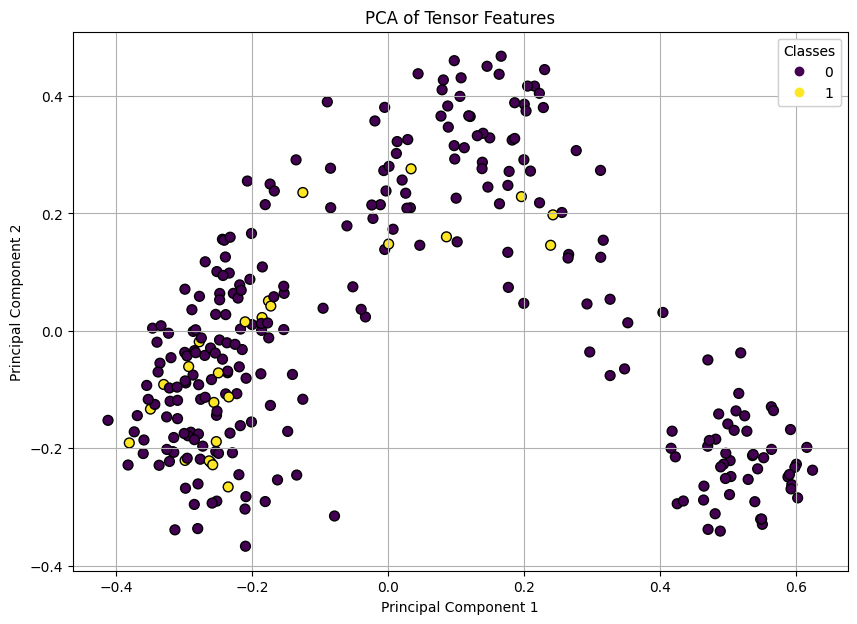

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
torch.Tensor(embedds).shape


data = embedds[0,:,:].reshape(289, 768)

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA of Tensor Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Add a color bar
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

In [59]:
lof_scores = []
lof_decision = []

for i in range(len(embedds)):
    feature_maps = embedds[i]
    flattened_feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(flattened_feature_maps)

    clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)


    outliers_lof = clf_lof.fit_predict(features_scaled)
    lof_score = -clf_lof.negative_outlier_factor_
    lof_decision.append(outliers_lof)
    lof_scores.append(lof_score)
    


In [60]:
lof_scores_column_sums = np.array(lof_scores).sum(axis=0)
lof_decisions_column_sums = np.array(lof_decision).sum(axis=0)

In [61]:
lof_decisions_column_sums

array([352, 394, 386, 300, 356, 380, 378, 378, 360, 358, 330, 314, 364,
       342, 350, 402, 392, 384, 394, 338, 334, 352, 318, 366, 356, 338,
       306, 356, 356, 348, 360, 386, 420, 364, 388, 360, 330, 336, 384,
       328, 384, 386, 274, 376, 374, 370, 372, 336, 382, 356, 392, 404,
       388, 360, 372, 402, 384, 362, 374, 366, 338, 338, 378, 354, 362,
       382, 346, 392, 382, 326, 402, 374, 378, 382, 380, 404, 346, 356,
       318, 396, 370, 382, 380, 308, 410, 402, 376, 306, 376, 410, 350,
       324, 318, 404, 300, 316, 394, 370, 248, 354, 364, 364, 372, 384,
       404, 350, 242, 404, 378, 396, 400, 366, 348, 388, 362, 384, 400,
       322, 368, 314, 350, 356, 320, 324, 414, 330, 364, 292, 304, 360,
       360, 356, 380, 366, 408, 388, 372, 396, 360, 338, 244, 394, 392,
       298, 272, 376, 250, 290, 386, 370, 400, 398, 354, 360, 360, 354,
       348, 328, 408, 364, 380, 352, 332, 242, 328, 344, 368, 364, 366,
       406, 356, 380, 388, 306, 364, 382, 342, 404, 378, 312, 27

In [63]:
scaler = MinMaxScaler()
scores_scaled = scaler.fit_transform(lof_scores_column_sums.reshape(-1, 1)).flatten()
scores=1 - scores_scaled
scores

array([0.9975666 , 0.9983126 , 0.9979253 , 0.99999964, 0.9999661 ,
       0.9989247 , 0.9783544 , 0.9975266 , 0.99967843, 0.99816966,
       0.9991713 , 0.99661744, 0.9735161 , 0.9997723 , 0.97136694,
       0.99516374, 0.9996505 , 0.9999998 , 0.9983115 , 0.9999995 ,
       0.99993265, 0.9998923 , 0.99343014, 0.99999994, 0.9998887 ,
       0.9965972 , 0.99649274, 0.9999433 , 0.9899693 , 0.9998965 ,
       0.998776  , 0.99932057, 0.9969897 , 0.9998655 , 0.99999994,
       0.99822736, 0.9999993 , 0.9999845 , 0.97758794, 0.99986416,
       0.9997946 , 0.9949316 , 1.        , 0.9998917 , 0.9997452 ,
       0.99405885, 0.99004614, 0.9998959 , 0.99937624, 0.99995667,
       0.99543536, 0.99751735, 0.9805213 , 0.9994396 , 0.9936054 ,
       0.9928265 , 0.99798024, 0.99995023, 0.9972783 , 0.9998264 ,
       0.9992001 , 0.99984694, 0.98702943, 0.99942154, 0.9999329 ,
       0.99994916, 0.9798641 , 0.99988866, 0.99995065, 0.99033874,
       0.99986774, 0.99424046, 0.99972636, 0.9980445 , 0.92511

In [64]:
labels=np.array([0 if 'good' in path else 1 for path in experiment['train']])

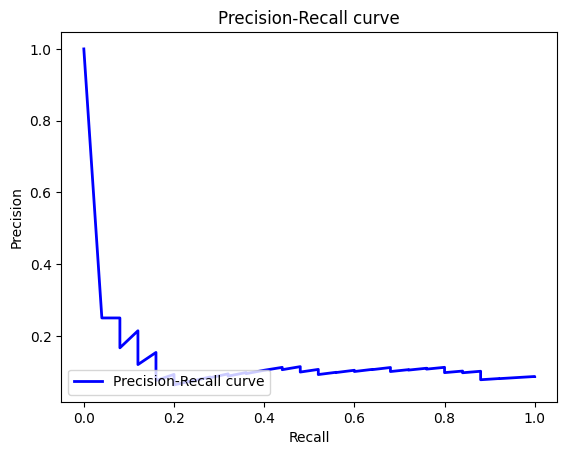

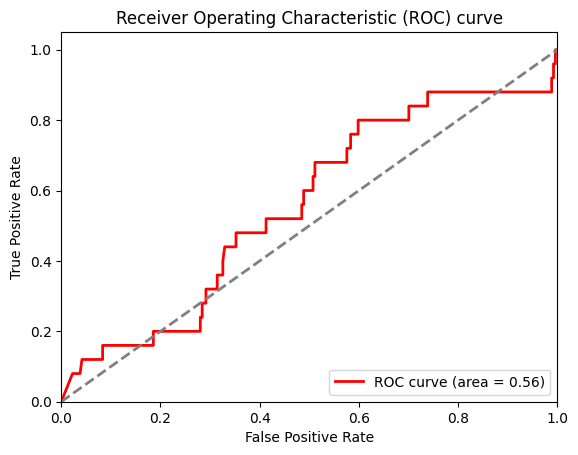

In [65]:
precision, recall, _ = precision_recall_curve(labels, scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
shuffled_final.shape
feature_maps = shuffled_final[:, 1, :, :]

feature_maps=torch.Tensor(feature_maps)
# Expanding feature maps to three channels
tensor_with_channels = feature_maps.unsqueeze(1).repeat(1, 3, 1, 1)

transformed_images = []
for i in range(tensor_with_channels.shape[0]):

    
    

    
    
    images = torch.stack(transformed_images)
    embeddings = model(images).last_hidden_state[:, 0].cpu()
    feature_maps = F.normalize(embeddings, p=2, dim=1).detach().numpy()

: 

In [ ]:
# Extract the first feature map for all images
ex = shuffled_final[ 14, :, :]
num_feature_maps = ex.shape[0]
num_cols = 28
num_rows = (num_feature_maps + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols, num_rows))

for i in range(num_feature_maps):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(ex[i], cmap='plasma')
    ax.axis('off')

# Hide any unused subplots
for i in range(num_feature_maps, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [ ]:
resdf=[]


for category in list(anocats.keys()):
    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_{category}.pkl'

    with open(file_path, 'rb') as file:
        input_= pickle.load(file)


    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_{category}.pkl'
    with open(file_path, 'rb') as file:
        input_sota= pickle.load(file)
        
        
        
    input_['Vit_beans; Cosine']=input_sota['Vit_beans; Cosine']

    input_["Vit_beans; LOF"]=input_sota["Vit_beans; LOF"]


    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_imagenet_{category}.pkl'
    with open(file_path, 'rb') as file:
        input_sota_im= pickle.load(file)
    input_['Vit_imagenet; Cosine']=input_sota_im['Vit_imagenet; Cosine']
    input_["Vit_imagenet; LOF"]=input_sota_im["Vit_imagenet; LOF"]
        
    
    res=pd.DataFrame(PR_ROC__stats(input_, category=category))
    resdf.append(res)

resdf=pd.concat(resdf)

['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO


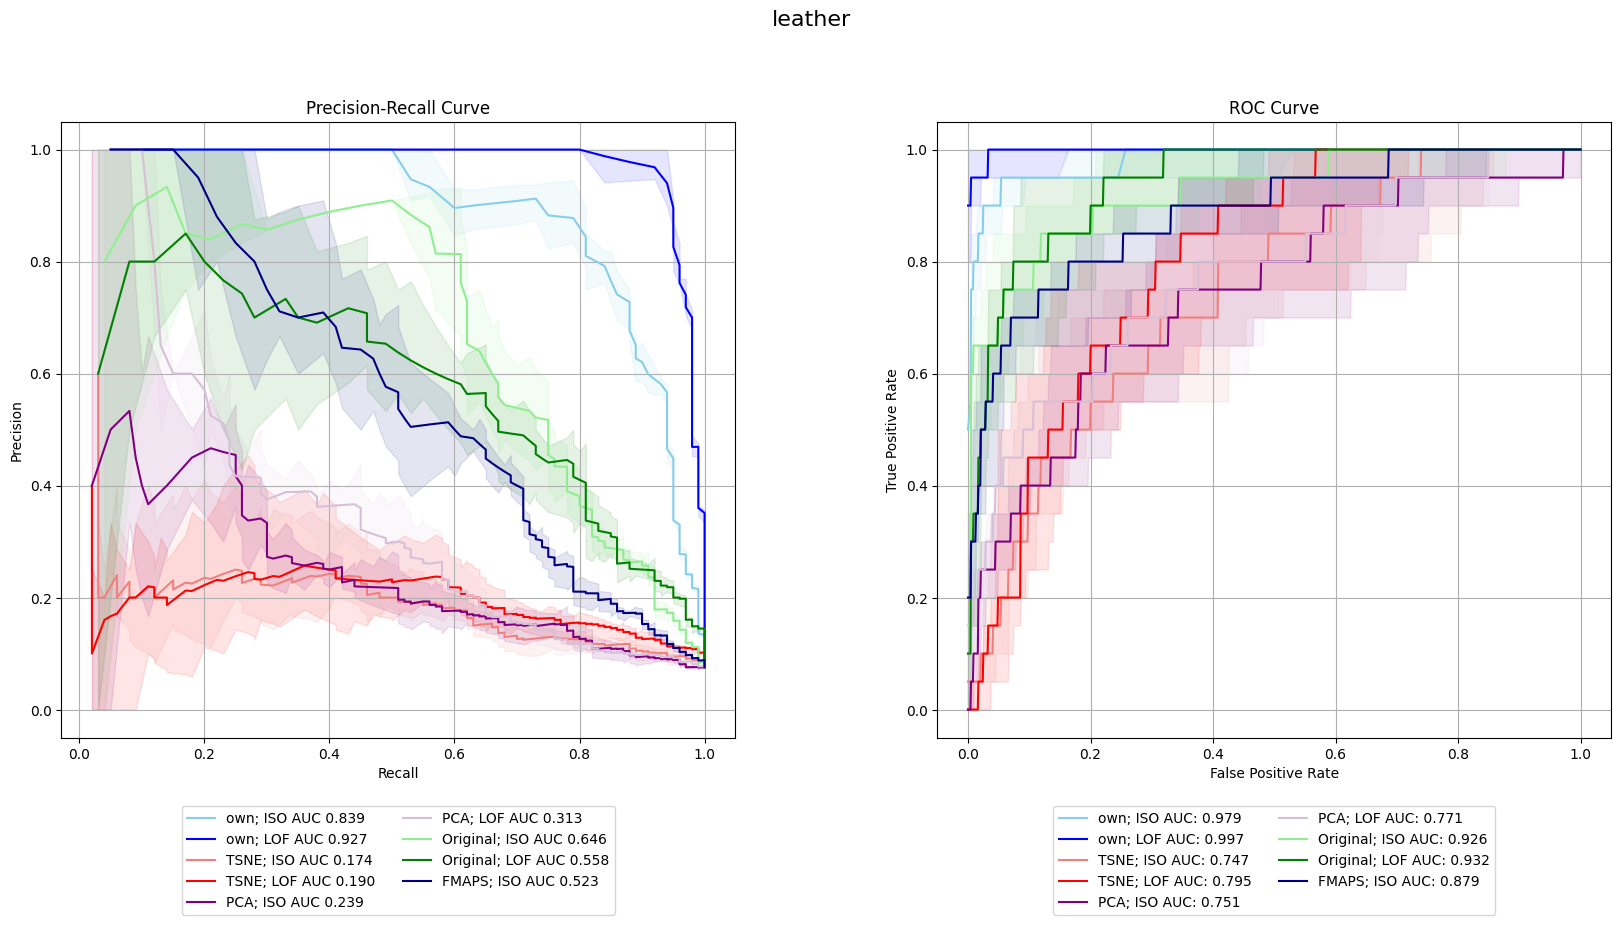

In [ ]:
import pickle

file_path = '/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_leather.pkl'

with open(file_path, 'rb') as file:
    input_= pickle.load(file)

input_.keys()
PR_ROC_runs(data_input=input_, category="leather")

In [2]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from PIL import Image
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import numpy as np

def refine_paths(experiment, args, additional_embedding=None):
    path_list = experiment['train']

    def load_image(filename, crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, aligned=False) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())

    shuffled_final = np.array(featuremaps).squeeze()



    isolation_outliers = []
    lof_outliers = []

    for i in range(shuffled_final.shape[1]):
        feature_maps = shuffled_final[:, i, :, :]
        
        if additional_embedding:
            feature_maps=torch.Tensor(feature_maps)
            # Expanding feature maps to three channels
            tensor_with_channels = feature_maps.unsqueeze(1).repeat(1, 3, 1, 1)
            tensor_with_channels.shape

            def transform_tensor(tensor, transform):
                transformed_images = torch.zeros((tensor.shape[0], 3, extractor.size["height"], extractor.size["height"]))
                for i in range(tensor.shape[0]):
                    image = tensor[i]  # Extract each image
                    image = T.ToPILImage()(image)  # Convert to PIL Image
                    image = transform(image)  # Apply transformations
                    transformed_images[i] = image  # Store transformed image
                return transformed_images

            # Apply the transformation chain to each image in the tensor
            transformed_tensor = transform_tensor(tensor_with_channels, transformation_chain)

            embeddings = model(transformed_tensor).last_hidden_state[:, 0].cpu()
            feature_maps = F.normalize(embeddings, p=2, dim=1).detach().numpy()

        else:
            pass
        
        flattened_feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(flattened_feature_maps)

        clf_isolation = IsolationForest(contamination=args.assumed_contamination_rate)
        outliers_isolation = clf_isolation.fit_predict(features_scaled)
        isolation_outliers.append(outliers_isolation)
        
        clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
        outliers_lof = clf_lof.fit_predict(features_scaled)
        lof_scores = -clf_lof.negative_outlier_factor_
        lof_outliers.append(outliers_lof)

    isolation_outliers = np.array(isolation_outliers)
    lof_outliers = np.array(lof_outliers)

    isolation_column_sums = isolation_outliers.sum(axis=0)
    lof_column_sums = lof_outliers.sum(axis=0)

    remove_inds = np.array(lof_column_sums).argsort()[:int(args.assumed_contamination_rate * len(lof_column_sums))]
    selected_paths = [path_list[i] for i in remove_inds]
    refined_paths = [path for path in path_list if path not in selected_paths]

    experiment['isoforest_scores'] = isolation_column_sums.tolist()
    experiment['lof_scores'] = lof_column_sums.tolist()
    experiment['lof_refined_paths'] = refined_paths

    return experiment


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

run completed


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

run completed


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

run completed


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

run completed


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

run completed
['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_beans; LOF', 'Vit_beans; Cosine']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO
Vit_beans; LOF


/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

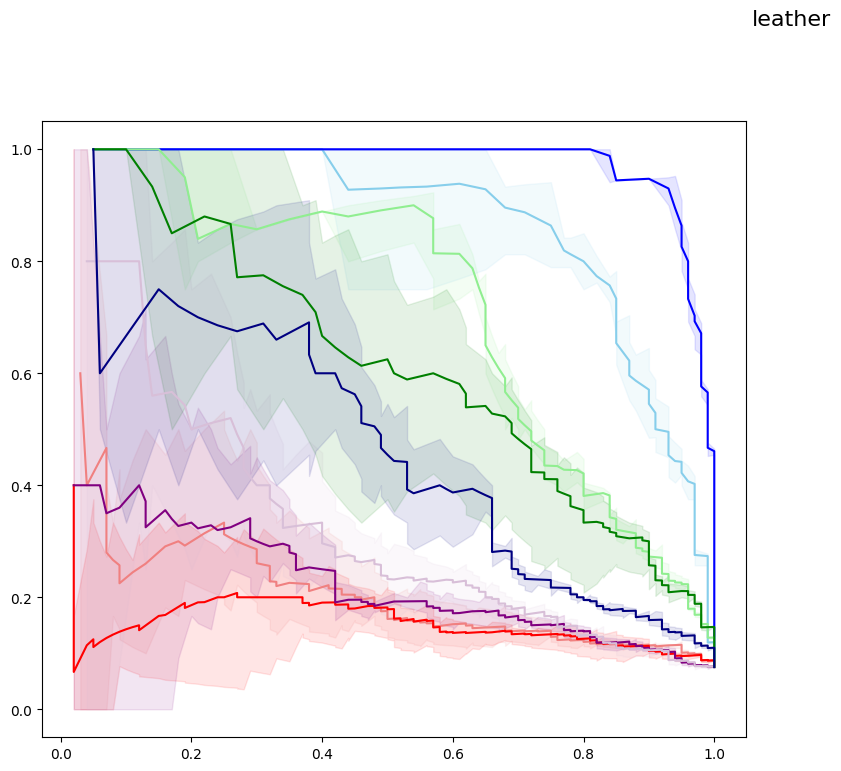

In [5]:

import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],'own; ISO':[],'own; LOF':[],'TSNE; ISO':[],'TSNE; LOF':[],'PCA; ISO':[],'PCA; LOF':[],'Original; ISO':[],'Original; LOF':[],'FMAPS; ISO':[],"Vit_beans; LOF":[],"Vit_beans; Cosine":[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
    with open(path, 'r') as file:
        experiment = json.load(file)
    ############################################################################## OWN REFINEMENT FUNCTION
    experiment_refined=refine_paths(experiment,args,additional_embedding=False) 
    labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]
    data['paths'].append(experiment_refined['train'])
    data['gt_labels'].append(labels)
    data['own; ISO'].append(np.array(experiment_refined['isoforest_scores']))
    data['own; LOF'].append(np.array(experiment_refined['lof_scores']))
    
    ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
    
    img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
    img_array = np.array([img.numpy().flatten() for img in img_list])
    
    #PCA
    pca = PCA(n_components=2, random_state=args.seed)
    pca_results = pca.fit_transform(img_array)
    lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
    lof_pca_preds = lof_pca.fit_predict(pca_results)
    lof_pca_scores = -lof_pca.negative_outlier_factor_
    
    isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
    isf_pca.fit(pca_results)
    isf_pca_preds = isf_pca.predict(pca_results)
    iso_scores = -isf_pca.decision_function(pca_results)
    

    
    #TSNE
    tsne = TSNE(n_components=2, random_state=args.seed)
    tsne_results = tsne.fit_transform(img_array)
    
    lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
    lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
    lof_tsne_scores = -lof_tsne.negative_outlier_factor_
    isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
    isf_tsne.fit(tsne_results)
    isf_tsne_preds = isf_tsne.predict(tsne_results)
    isf_tsne_scores = -isf_tsne.decision_function(tsne_results)
    
    scaler = MinMaxScaler()
    data['TSNE; ISO'].append(scaler.fit_transform(np.array(isf_tsne_scores).reshape(-1, 1)).flatten())
    data['TSNE; LOF'].append(scaler.fit_transform(np.array(lof_tsne_scores).reshape(-1, 1)).flatten())
    data['PCA; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
    data['PCA; LOF'].append( scaler.fit_transform(np.array(lof_pca_scores).reshape(-1, 1)).flatten())
    
    ############################################################################# on orig images
    # LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    lof_pred = lof.fit_predict(img_array)
    lof_scores = -lof.negative_outlier_factor_
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
    iso_forest.fit(img_array)
    iso_scores = -iso_forest.decision_function(img_array)

    data['Original; ISO'].append( scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
    data['Original; LOF'].append(scaler.fit_transform(np.array(lof_scores).reshape(-1, 1)).flatten())
    # print('run done')
    
    
    #################################### on the features
    fmaps_images=feature_extraction(experiment_refined,args)

    img_array = np.array([img.flatten() for img in fmaps_images])
    iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
    iso_forest.fit(img_array)
    iso_scores = -iso_forest.decision_function(img_array)
    
    data['FMAPS; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())

    #############################################################
    
    
    # images=[]
    # for filename in experiment_refined['train']:
    #     img = Image.open(filename)
    #     if img.mode == 'L':  # Check if the image is grayscale (single channel)
    #         img = img.convert('RGB')  # Convert grayscale to RGB (three channels)
    #     images.append(img)
    
    # images=[transformation_chain(image) for image in images]
    # images=torch.stack(images)
    # embeddings = model(images).last_hidden_state[:, 0].cpu()
    # embeddings = F.normalize(embeddings, p=2, dim=1)
    
    # cosine_similarity_matrix = torch.mm(embeddings, embeddings.t())
    # col_sums = np.sum(cosine_similarity_matrix.detach().numpy(), axis=0)
    # colsums_sorted = scaler.fit_transform(col_sums.reshape(-1, 1)).flatten()
    # colsums_sorted=1-colsums_sorted
    # data["Vit_beans; Cosine"].append(colsums_sorted)
    # embeddings_=embeddings.detach().numpy()

    # lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    # outlier_labels = lof.fit_predict(embeddings_)
    # anomaly_scores = -lof.negative_outlier_factor_
    
    # data["Vit_beans; LOF"].append(scaler.fit_transform(np.array(anomaly_scores).reshape(-1, 1)).flatten())
    print("run completed")
    
filename = f'/home/bule/projects/UTRAD/Refinement_Comparison_{category}.pkl'


# # Dump the dictionary to a pickle file
# with open(filename, 'wb') as file:
#     pickle.dump(data, file)
    
PR_ROC_runs(data_input=data, category=category)


In [ ]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "carpet"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],"Vit_beans; LOF":[],"Vit_beans; Cosine":[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
    with open(path, 'r') as file:
        experiment = json.load(file)
    ############################################################################## OWN REFINEMENT FUNCTION
    labels=[0 if 'good' in path else 1 for path in experiment['train']]


    scaler = MinMaxScaler()

    images=[]
    for filename in experiment['train']:
        img = Image.open(filename)
        if img.mode == 'L':  # Check if the image is grayscale (single channel)
            img = img.convert('RGB')  # Convert grayscale to RGB (three channels)
        images.append(img)
    
    images=[transformation_chain(image) for image in images]
    images=torch.stack(images)
    embeddings = model(images).last_hidden_state[:, 0].cpu()
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    cosine_similarity_matrix = torch.mm(embeddings, embeddings.t())
    col_sums = np.sum(cosine_similarity_matrix.detach().numpy(), axis=0)
    colsums_sorted = scaler.fit_transform(col_sums.reshape(-1, 1)).flatten()
    colsums_sorted=1-colsums_sorted
    data["Vit_beans; Cosine"].append(colsums_sorted)
    embeddings_=embeddings.detach().numpy()

    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outlier_labels = lof.fit_predict(embeddings_)
    anomaly_scores = -lof.negative_outlier_factor_
    
    data["Vit_beans; LOF"].append(scaler.fit_transform(np.array(anomaly_scores).reshape(-1, 1)).flatten())
    print("run completed")
    
filename = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA{category}.pkl'


# Dump the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data, file)
    
# PR_ROC_runs(data_input=data, category=category)

NameError: name 'MinMaxScaler' is not defined

In [ ]:
data

{'paths': [],
 'gt_labels': [],
 'Vit_beans; LOF': [array([0.09705764, 0.02927089, 0.06585699, 0.02964324, 0.20548308,
         0.11855507, 0.03389764, 0.22350442, 0.0840081 , 0.15763408,
         0.11162812, 0.08309656, 0.00708872, 0.17352015, 0.744318  ,
         0.03428435, 0.10929912, 0.06180006, 0.04475033, 0.00243193,
         0.02448541, 0.05224538, 0.4041934 , 0.03629971, 0.0329178 ,
         0.1415925 , 0.09857082, 0.01299971, 0.02130032, 0.09242594,
         0.12383282, 0.0438863 , 0.04778802, 0.05985928, 0.3236878 ,
         0.03652984, 0.12687486, 0.03024048, 0.04988259, 0.03250283,
         0.03113014, 0.13320047, 0.84685314, 0.03312212, 0.00649893,
         0.04254824, 0.13064373, 0.05542839, 0.11466312, 0.02878934,
         0.00391579, 0.03711051, 0.04500747, 0.03837067, 0.250364  ,
         0.03104186, 0.08429885, 0.02008599, 0.07416326, 0.02657348,
         0.05886078, 0.01015264, 0.01679558, 0.06102097, 0.01605582,
         0.01042879, 0.04912812, 0.02836168, 0.093881

########## similarieties with embeddings

In [ ]:
https://huggingface.co/blog/image-similarity

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO


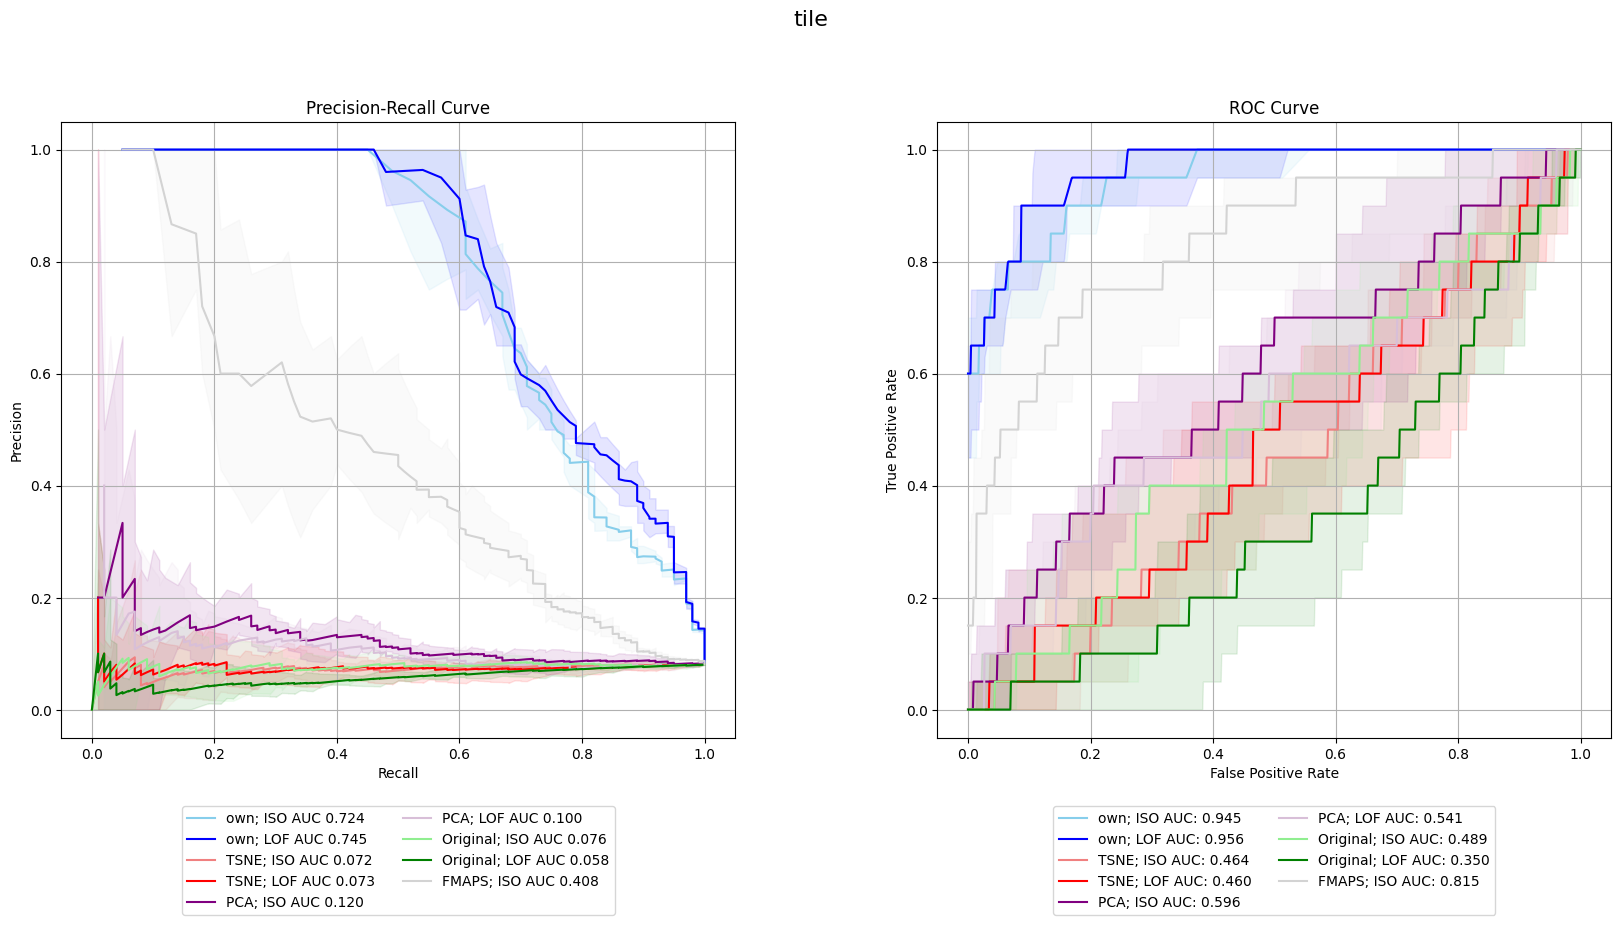

In [ ]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "tile"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],'own; ISO':[],'own; LOF':[],'TSNE; ISO':[],'TSNE; LOF':[],'PCA; ISO':[],'PCA; LOF':[],'Original; ISO':[],'Original; LOF':[],'FMAPS; ISO':[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
    with open(path, 'r') as file:
        experiment = json.load(file)
    ############################################################################## OWN REFINEMENT FUNCTION
    experiment_refined=refine_paths(experiment,args) 
    labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]
    data['paths'].append(experiment_refined['train'])
    data['gt_labels'].append(labels)
    data['own; ISO'].append(np.array(experiment_refined['isoforest_scores']))
    data['own; LOF'].append(np.array(experiment_refined['lof_scores']))
    
    ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
    
    img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
    img_array = np.array([img.numpy().flatten() for img in img_list])
    
    #PCA
    pca = PCA(n_components=2, random_state=args.seed)
    pca_results = pca.fit_transform(img_array)
    lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
    lof_pca_preds = lof_pca.fit_predict(pca_results)
    lof_pca_scores = -lof_pca.negative_outlier_factor_
    
    isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
    isf_pca.fit(pca_results)
    isf_pca_preds = isf_pca.predict(pca_results)
    iso_scores = -isf_pca.decision_function(pca_results)
    
    
    #TSNE
    tsne = TSNE(n_components=2, random_state=args.seed)
    tsne_results = tsne.fit_transform(img_array)
    
    lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
    lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
    lof_tsne_scores = -lof_tsne.negative_outlier_factor_
    isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
    isf_tsne.fit(tsne_results)
    isf_tsne_preds = isf_tsne.predict(tsne_results)
    isf_tsne_scores = -isf_tsne.decision_function(tsne_results)
    
    scaler = MinMaxScaler()
    data['TSNE; ISO'].append(scaler.fit_transform(np.array(isf_tsne_scores).reshape(-1, 1)).flatten())
    data['TSNE; LOF'].append(scaler.fit_transform(np.array(lof_tsne_scores).reshape(-1, 1)).flatten())
    data['PCA; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
    data['PCA; LOF'].append( scaler.fit_transform(np.array(lof_pca_scores).reshape(-1, 1)).flatten())
    
    ############################################################################# on orig images
    # LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    lof_pred = lof.fit_predict(img_array)
    lof_scores = -lof.negative_outlier_factor_
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
    iso_forest.fit(img_array)
    iso_scores = -iso_forest.decision_function(img_array)

    data['Original; ISO'].append( scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
    data['Original; LOF'].append(scaler.fit_transform(np.array(lof_scores).reshape(-1, 1)).flatten())
    # print('run done')
    
    
    #################################### on the features
    fmaps_images=feature_extraction(experiment_refined,args)

    img_array = np.array([img.flatten() for img in fmaps_images])
    iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
    iso_forest.fit(img_array)
    iso_scores = -iso_forest.decision_function(img_array)
    
    data['FMAPS; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())

    
    
filename = f'/home/bule/projects/UTRAD/Refinement_Comparison_{category}.pkl'


# Dump the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data, file)
    
PR_ROC_runs(data_input=data, category=category)

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF


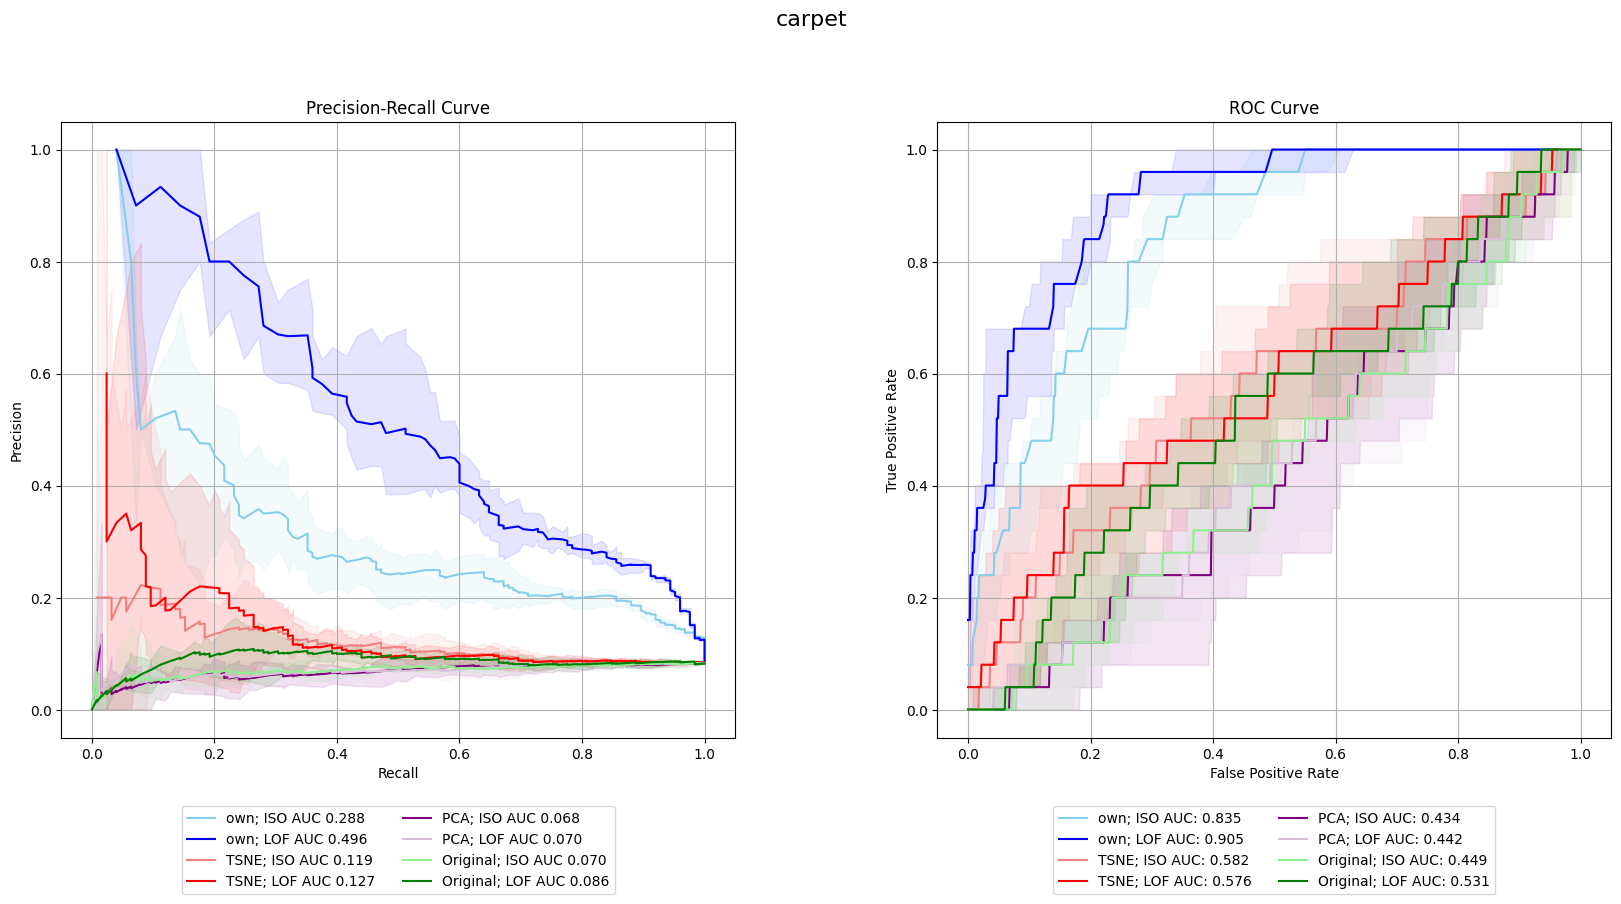

In [ ]:
# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "carpet"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],'own; ISO':[],'own; LOF':[],'TSNE; ISO':[],'TSNE; LOF':[],'PCA; ISO':[],'PCA; LOF':[],'Original; ISO':[],'Original; LOF':[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
     with open(path, 'r') as file:
          experiment = json.load(file)

     ############################################################################## OWN REFINEMENT FUNCTION
     experiment_refined=refine_paths(experiment,args) 
     labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]

     data['paths'].append(experiment_refined['train'])
     data['gt_labels'].append(labels)
     data['own; ISO'].append(np.array(experiment_refined['isoforest_scores']))
     data['own; LOF'].append(np.array(experiment_refined['lof_scores']))
     
     ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
     
     img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
     img_array = np.array([img.numpy().flatten() for img in img_list])

     #PCA

     pca = PCA(n_components=2, random_state=args.seed)
     pca_results = pca.fit_transform(img_array)

     lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_pca_preds = lof_pca.fit_predict(pca_results)
     lof_pca_scores = -lof_pca.negative_outlier_factor_
     

     
     
     isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_pca.fit(pca_results)
     isf_pca_preds = isf_pca.predict(pca_results)
     iso_scores = -isf_pca.decision_function(pca_results)
     
     
     
     #TSNE
     tsne = TSNE(n_components=2, random_state=args.seed)
     tsne_results = tsne.fit_transform(img_array)
     
     lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
     lof_tsne_scores = -lof_tsne.negative_outlier_factor_


     isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_tsne.fit(tsne_results)
     isf_tsne_preds = isf_tsne.predict(tsne_results)
     isf_tsne_scores = -isf_tsne.decision_function(tsne_results)
     
     #results
    #  data['TSNE; ISO'].append(np.array(isf_tsne_scores))
    #  data['TSNE; LOF'].append(np.array(lof_tsne_scores))
    #  data['PCA; ISO'].append(np.array(iso_scores))
    #  data['PCA; LOF'].append(np.array(lof_pca_scores))
     
     scaler = MinMaxScaler()
     data['TSNE; ISO'].append(scaler.fit_transform(np.array(isf_tsne_scores).reshape(-1, 1)).flatten())
     data['TSNE; LOF'].append(scaler.fit_transform(np.array(lof_tsne_scores).reshape(-1, 1)).flatten())
     data['PCA; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['PCA; LOF'].append( scaler.fit_transform(np.array(lof_pca_scores).reshape(-1, 1)).flatten())


     
     ############################################################################# on orig images
     # LOF
     lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
     lof_pred = lof.fit_predict(img_array)
     lof_scores = -lof.negative_outlier_factor_

     # Isolation Forest
     iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
     iso_forest.fit(img_array)
     iso_scores = -iso_forest.decision_function(img_array)

    #  data['Original; ISO'].append(np.array(iso_scores))
    #  data['Original; LOF'].append(np.array(lof_scores))
     
     
     data['Original; ISO'].append( scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['Original; LOF'].append(scaler.fit_transform(np.array(lof_scores).reshape(-1, 1)).flatten())
     # print('run done')
     
     
filename = f'/home/bule/projects/UTRAD/Refinement_Comparison_{category}.pkl'
# Dump the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data, file)
    
PR_ROC_runs(data_input=data, category=category)

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF


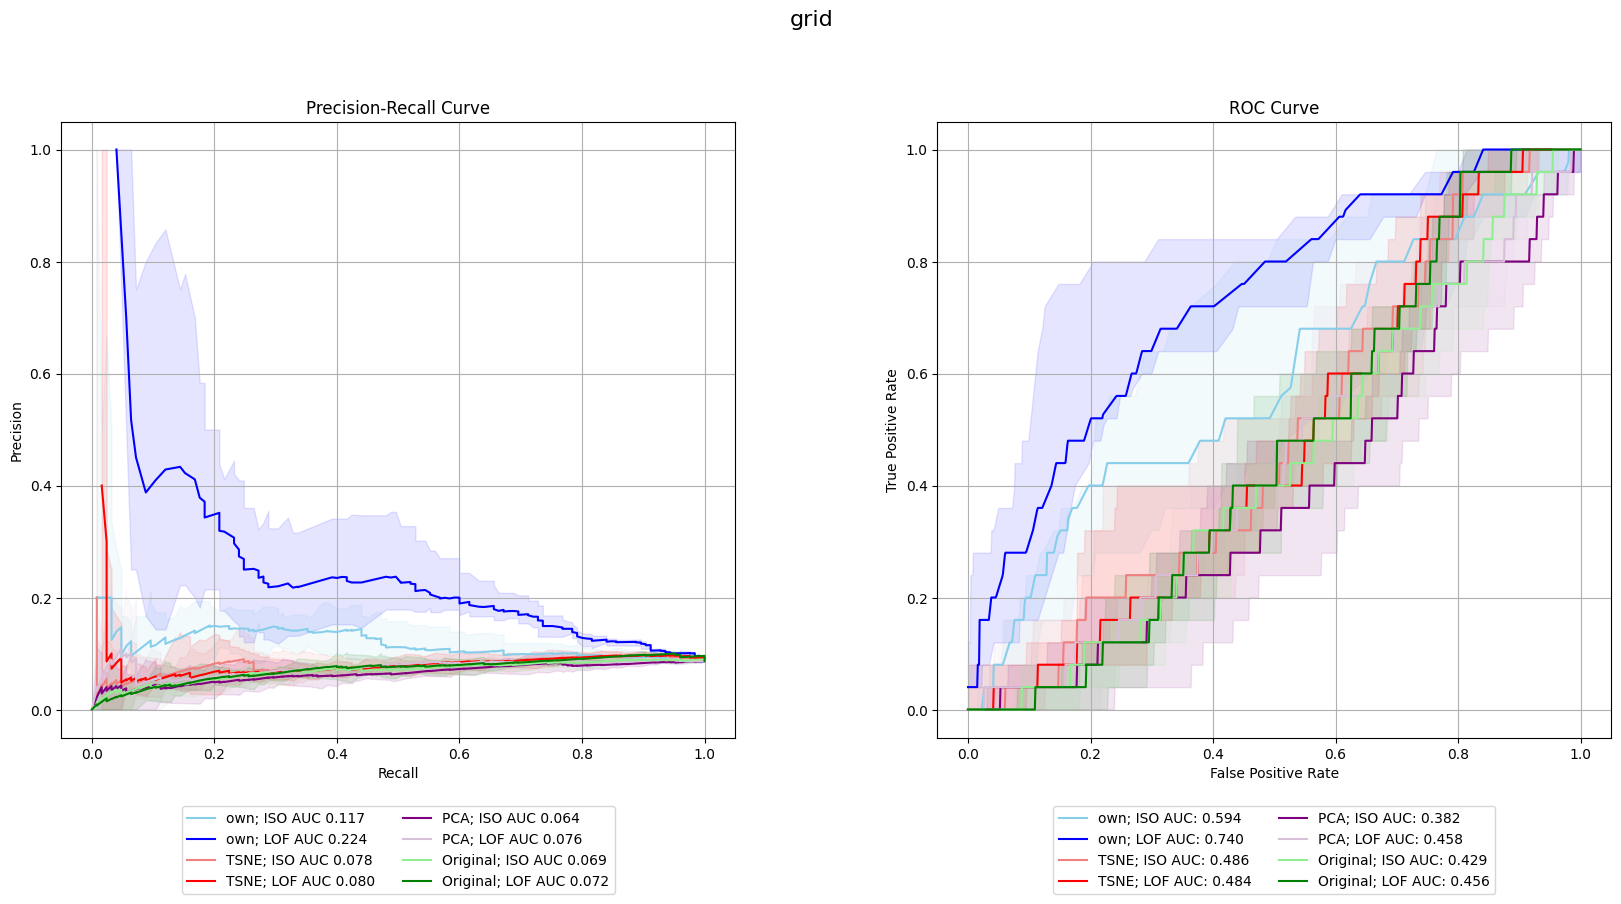

In [ ]:
# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "grid"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],'own; ISO':[],'own; LOF':[],'TSNE; ISO':[],'TSNE; LOF':[],'PCA; ISO':[],'PCA; LOF':[],'Original; ISO':[],'Original; LOF':[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
     with open(path, 'r') as file:
          experiment = json.load(file)

     ############################################################################## OWN REFINEMENT FUNCTION
     experiment_refined=refine_paths(experiment,args) 
     labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]

     data['paths'].append(experiment_refined['train'])
     data['gt_labels'].append(labels)
     data['own; ISO'].append(np.array(experiment_refined['isoforest_scores']))
     data['own; LOF'].append(np.array(experiment_refined['lof_scores']))
     
     ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
     
     img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
     img_array = np.array([img.numpy().flatten() for img in img_list])

     #PCA

     pca = PCA(n_components=2, random_state=args.seed)
     pca_results = pca.fit_transform(img_array)

     lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_pca_preds = lof_pca.fit_predict(pca_results)
     lof_pca_scores = -lof_pca.negative_outlier_factor_
     

     
     
     isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_pca.fit(pca_results)
     isf_pca_preds = isf_pca.predict(pca_results)
     iso_scores = -isf_pca.decision_function(pca_results)
     
     
     
     #TSNE
     tsne = TSNE(n_components=2, random_state=args.seed)
     tsne_results = tsne.fit_transform(img_array)
     
     lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
     lof_tsne_scores = -lof_tsne.negative_outlier_factor_


     isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_tsne.fit(tsne_results)
     isf_tsne_preds = isf_tsne.predict(tsne_results)
     isf_tsne_scores = -isf_tsne.decision_function(tsne_results)
     
     #results
    #  data['TSNE; ISO'].append(np.array(isf_tsne_scores))
    #  data['TSNE; LOF'].append(np.array(lof_tsne_scores))
    #  data['PCA; ISO'].append(np.array(iso_scores))
    #  data['PCA; LOF'].append(np.array(lof_pca_scores))
     
     scaler = MinMaxScaler()
     data['TSNE; ISO'].append(scaler.fit_transform(np.array(isf_tsne_scores).reshape(-1, 1)).flatten())
     data['TSNE; LOF'].append(scaler.fit_transform(np.array(lof_tsne_scores).reshape(-1, 1)).flatten())
     data['PCA; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['PCA; LOF'].append( scaler.fit_transform(np.array(lof_pca_scores).reshape(-1, 1)).flatten())


     
     ############################################################################# on orig images
     # LOF
     lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
     lof_pred = lof.fit_predict(img_array)
     lof_scores = -lof.negative_outlier_factor_

     # Isolation Forest
     iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
     iso_forest.fit(img_array)
     iso_scores = -iso_forest.decision_function(img_array)

    #  data['Original; ISO'].append(np.array(iso_scores))
    #  data['Original; LOF'].append(np.array(lof_scores))
     
     
     data['Original; ISO'].append( scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['Original; LOF'].append(scaler.fit_transform(np.array(lof_scores).reshape(-1, 1)).flatten())
     # print('run done')
     
     
filename = f'/home/bule/projects/UTRAD/Refinement_Comparison_{category}.pkl'
# Dump the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data, file)
    
PR_ROC_runs(data_input=data, category=category)

In [ ]:
# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "tile"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],'own; ISO':[],'own; LOF':[],'TSNE; ISO':[],'TSNE; LOF':[],'PCA; ISO':[],'PCA; LOF':[],'Original; ISO':[],'Original; LOF':[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
     with open(path, 'r') as file:
          experiment = json.load(file)

     ############################################################################## OWN REFINEMENT FUNCTION
     experiment_refined=refine_paths(experiment,args) 
     labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]

     data['paths'].append(experiment_refined['train'])
     data['gt_labels'].append(labels)
     data['own; ISO'].append(np.array(experiment_refined['isoforest_scores']))
     data['own; LOF'].append(np.array(experiment_refined['lof_scores']))
     
     ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
     
     img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
     img_array = np.array([img.numpy().flatten() for img in img_list])

     #PCA

     pca = PCA(n_components=2, random_state=args.seed)
     pca_results = pca.fit_transform(img_array)

     lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_pca_preds = lof_pca.fit_predict(pca_results)
     lof_pca_scores = -lof_pca.negative_outlier_factor_
     

     
     
     isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_pca.fit(pca_results)
     isf_pca_preds = isf_pca.predict(pca_results)
     iso_scores = -isf_pca.decision_function(pca_results)
     
     
     
     #TSNE
     tsne = TSNE(n_components=2, random_state=args.seed)
     tsne_results = tsne.fit_transform(img_array)
     
     lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
     lof_tsne_scores = -lof_tsne.negative_outlier_factor_


     isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_tsne.fit(tsne_results)
     isf_tsne_preds = isf_tsne.predict(tsne_results)
     isf_tsne_scores = -isf_tsne.decision_function(tsne_results)
     
     #results
    #  data['TSNE; ISO'].append(np.array(isf_tsne_scores))
    #  data['TSNE; LOF'].append(np.array(lof_tsne_scores))
    #  data['PCA; ISO'].append(np.array(iso_scores))
    #  data['PCA; LOF'].append(np.array(lof_pca_scores))
     
     scaler = MinMaxScaler()
     data['TSNE; ISO'].append(scaler.fit_transform(np.array(isf_tsne_scores).reshape(-1, 1)).flatten())
     data['TSNE; LOF'].append(scaler.fit_transform(np.array(lof_tsne_scores).reshape(-1, 1)).flatten())
     data['PCA; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['PCA; LOF'].append( scaler.fit_transform(np.array(lof_pca_scores).reshape(-1, 1)).flatten())


     
     ############################################################################# on orig images
     # LOF
     lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
     lof_pred = lof.fit_predict(img_array)
     lof_scores = -lof.negative_outlier_factor_

     # Isolation Forest
     iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
     iso_forest.fit(img_array)
     iso_scores = -iso_forest.decision_function(img_array)

    #  data['Original; ISO'].append(np.array(iso_scores))
    #  data['Original; LOF'].append(np.array(lof_scores))
     
     
     data['Original; ISO'].append( scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['Original; LOF'].append(scaler.fit_transform(np.array(lof_scores).reshape(-1, 1)).flatten())
     # print('run done')
     
     
filename = f'/home/bule/projects/UTRAD/Refinement_Comparison_{category}.pkl'
# Dump the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data, file)
    
PR_ROC_runs(data_input=data, category=category)

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223:

In [ ]:
# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "wood"
args = TrainOptions(category)

data = {'paths':[],'gt_labels':[],'own; ISO':[],'own; LOF':[],'TSNE; ISO':[],'TSNE; LOF':[],'PCA; ISO':[],'PCA; LOF':[],'Original; ISO':[],'Original; LOF':[]}
paths=[f'/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_{i}-{category}/experiment_paths.json' for i in range(1,6)]

for path in paths:
     with open(path, 'r') as file:
          experiment = json.load(file)

     ############################################################################## OWN REFINEMENT FUNCTION
     experiment_refined=refine_paths(experiment,args) 
     labels=[0 if 'good' in path else 1 for path in experiment_refined['train']]

     data['paths'].append(experiment_refined['train'])
     data['gt_labels'].append(labels)
     data['own; ISO'].append(np.array(experiment_refined['isoforest_scores']))
     data['own; LOF'].append(np.array(experiment_refined['lof_scores']))
     
     ############################################################################ ON ORIGINAL IMAGE DATA PCA AND TSNE LOF AND ISO
     
     img_list = [load_image(path, aligned=False) for path in experiment_refined['train']]
     img_array = np.array([img.numpy().flatten() for img in img_list])

     #PCA

     pca = PCA(n_components=2, random_state=args.seed)
     pca_results = pca.fit_transform(img_array)

     lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_pca_preds = lof_pca.fit_predict(pca_results)
     lof_pca_scores = -lof_pca.negative_outlier_factor_
     

     
     
     isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_pca.fit(pca_results)
     isf_pca_preds = isf_pca.predict(pca_results)
     iso_scores = -isf_pca.decision_function(pca_results)
     
     
     
     #TSNE
     tsne = TSNE(n_components=2, random_state=args.seed)
     tsne_results = tsne.fit_transform(img_array)
     
     lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
     lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
     lof_tsne_scores = -lof_tsne.negative_outlier_factor_


     isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
     isf_tsne.fit(tsne_results)
     isf_tsne_preds = isf_tsne.predict(tsne_results)
     isf_tsne_scores = -isf_tsne.decision_function(tsne_results)
     
     #results
    #  data['TSNE; ISO'].append(np.array(isf_tsne_scores))
    #  data['TSNE; LOF'].append(np.array(lof_tsne_scores))
    #  data['PCA; ISO'].append(np.array(iso_scores))
    #  data['PCA; LOF'].append(np.array(lof_pca_scores))
     
     scaler = MinMaxScaler()
     data['TSNE; ISO'].append(scaler.fit_transform(np.array(isf_tsne_scores).reshape(-1, 1)).flatten())
     data['TSNE; LOF'].append(scaler.fit_transform(np.array(lof_tsne_scores).reshape(-1, 1)).flatten())
     data['PCA; ISO'].append(scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['PCA; LOF'].append( scaler.fit_transform(np.array(lof_pca_scores).reshape(-1, 1)).flatten())


     
     ############################################################################# on orig images
     # LOF
     lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
     lof_pred = lof.fit_predict(img_array)
     lof_scores = -lof.negative_outlier_factor_

     # Isolation Forest
     iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
     iso_forest.fit(img_array)
     iso_scores = -iso_forest.decision_function(img_array)

    #  data['Original; ISO'].append(np.array(iso_scores))
    #  data['Original; LOF'].append(np.array(lof_scores))
     
     
     data['Original; ISO'].append( scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).flatten())
     data['Original; LOF'].append(scaler.fit_transform(np.array(lof_scores).reshape(-1, 1)).flatten())
     # print('run done')
     
     
     ####################################################################################  Transformer embeddings 
     
     
     
filename = f'/home/bule/projects/UTRAD/Refinement_Comparison_{category}.pkl'
# Dump the dictionary to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(data, file)
    
PR_ROC_runs(data_input=data, category=category)

### Examples on diff classes

PCA + LOF:
               precision    recall  f1-score   support

        Good       0.93      0.90      0.92       245
     Anomaly       0.11      0.15      0.13        20

    accuracy                           0.85       265
   macro avg       0.52      0.53      0.52       265
weighted avg       0.87      0.85      0.86       265

PCA + Isolation Forest:
               precision    recall  f1-score   support

        Good       0.94      0.91      0.93       245
     Anomaly       0.22      0.30      0.26        20

    accuracy                           0.87       265
   macro avg       0.58      0.61      0.59       265
weighted avg       0.89      0.87      0.88       265

t-SNE + LOF:
               precision    recall  f1-score   support

        Good       0.94      0.91      0.93       245
     Anomaly       0.22      0.30      0.26        20

    accuracy                           0.87       265
   macro avg       0.58      0.61      0.59       265
weighted avg       0.89

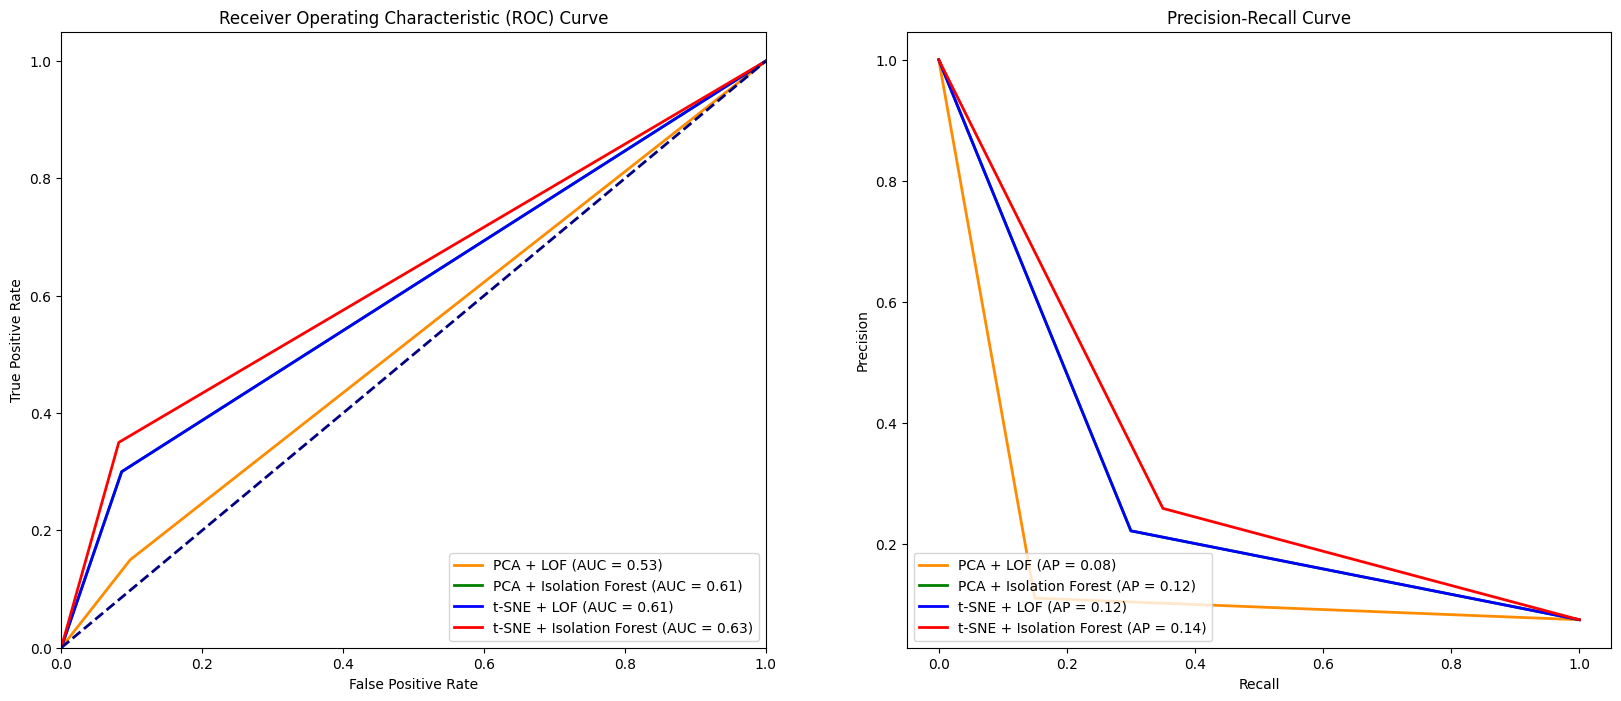

In [ ]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']

# Define the image loading function
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

# Load and preprocess the images
img_list = [load_image(path, aligned=False) for path in path_list]

# Create labels (0 for 'good', 1 for 'anomaly')
labels = [0 if 'good' in path else 1 for path in experiment['train']]

# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.numpy().flatten() for img in img_list])

# Apply PCA and t-SNE
pca = PCA(n_components=2, random_state=args.seed)
pca_results = pca.fit_transform(img_array)

tsne = TSNE(n_components=2, random_state=args.seed)
tsne_results = tsne.fit_transform(img_array)

# Apply LOF and Isolation Forest for anomaly detection on PCA results
lof_pca = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
lof_pca_preds = lof_pca.fit_predict(pca_results)
lof_pca_labels = (lof_pca_preds == -1).astype(int)  # 1 for anomalies, 0 for normal instances

isf_pca = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
isf_pca.fit(pca_results)
isf_pca_labels = isf_pca.predict(pca_results)
isf_pca_labels = (isf_pca_labels == -1).astype(int)  # 1 for anomalies, 0 for normal instances

# Apply LOF and Isolation Forest for anomaly detection on t-SNE results
lof_tsne = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
lof_tsne_preds = lof_tsne.fit_predict(tsne_results)
lof_tsne_labels = (lof_tsne_preds == -1).astype(int)  # 1 for anomalies, 0 for normal instances

isf_tsne = IsolationForest(contamination=args.assumed_contamination_rate, random_state=args.seed)
isf_tsne.fit(tsne_results)
isf_tsne_labels = isf_tsne.predict(tsne_results)
isf_tsne_labels = (isf_tsne_labels == -1).astype(int)  # 1 for anomalies, 0 for normal instances

# Generate classification reports
report_pca_lof = classification_report(labels, lof_pca_labels, target_names=['Good', 'Anomaly'])
report_pca_isf = classification_report(labels, isf_pca_labels, target_names=['Good', 'Anomaly'])
report_tsne_lof = classification_report(labels, lof_tsne_labels, target_names=['Good', 'Anomaly'])
report_tsne_isf = classification_report(labels, isf_tsne_labels, target_names=['Good', 'Anomaly'])

print("PCA + LOF:\n", report_pca_lof)
print("PCA + Isolation Forest:\n", report_pca_isf)
print("t-SNE + LOF:\n", report_tsne_lof)
print("t-SNE + Isolation Forest:\n", report_tsne_isf)

# Compute ROC curve and ROC area for each method
fpr_pca_lof, tpr_pca_lof, _ = roc_curve(labels, lof_pca_labels)
roc_auc_pca_lof = auc(fpr_pca_lof, tpr_pca_lof)

fpr_pca_isf, tpr_pca_isf, _ = roc_curve(labels, isf_pca_labels)
roc_auc_pca_isf = auc(fpr_pca_isf, tpr_pca_isf)

fpr_tsne_lof, tpr_tsne_lof, _ = roc_curve(labels, lof_tsne_labels)
roc_auc_tsne_lof = auc(fpr_tsne_lof, tpr_tsne_lof)

fpr_tsne_isf, tpr_tsne_isf, _ = roc_curve(labels, isf_tsne_labels)
roc_auc_tsne_isf = auc(fpr_tsne_isf, tpr_tsne_isf)

# Compute Precision-Recall curve and average precision for each method
precision_pca_lof, recall_pca_lof, _ = precision_recall_curve(labels, lof_pca_labels)
average_precision_pca_lof = average_precision_score(labels, lof_pca_labels)

precision_pca_isf, recall_pca_isf, _ = precision_recall_curve(labels, isf_pca_labels)
average_precision_pca_isf = average_precision_score(labels, isf_pca_labels)

precision_tsne_lof, recall_tsne_lof, _ = precision_recall_curve(labels, lof_tsne_labels)
average_precision_tsne_lof = average_precision_score(labels, lof_tsne_labels)

precision_tsne_isf, recall_tsne_isf, _ = precision_recall_curve(labels, isf_tsne_labels)
average_precision_tsne_isf = average_precision_score(labels, isf_tsne_labels)

# Plot ROC and Precision-Recall curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax1.plot(fpr_pca_lof, tpr_pca_lof, color='darkorange', lw=2, label=f'PCA + LOF (AUC = {roc_auc_pca_lof:.2f})')
ax1.plot(fpr_pca_isf, tpr_pca_isf, color='green', lw=2, label=f'PCA + Isolation Forest (AUC = {roc_auc_pca_isf:.2f})')
ax1.plot(fpr_tsne_lof, tpr_tsne_lof, color='blue', lw=2, label=f't-SNE + LOF (AUC = {roc_auc_tsne_lof:.2f})')
ax1.plot(fpr_tsne_isf, tpr_tsne_isf, color='red', lw=2, label=f't-SNE + Isolation Forest (AUC = {roc_auc_tsne_isf:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Precision-Recall curve
ax2.plot(recall_pca_lof, precision_pca_lof, color='darkorange', lw=2, label=f'PCA + LOF (AP = {average_precision_pca_lof:.2f})')
ax2.plot(recall_pca_isf, precision_pca_isf, color='green', lw=2, label=f'PCA + Isolation Forest (AP = {average_precision_pca_isf:.2f})')
ax2.plot(recall_tsne_lof, precision_tsne_lof, color='blue', lw=2, label=f't-SNE + LOF (AP = {average_precision_tsne_lof:.2f})')
ax2.plot(recall_tsne_isf, precision_tsne_isf, color='red', lw=2, label=f't-SNE + Isolation Forest (AP = {average_precision_tsne_isf:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.show()


(265, 196608)


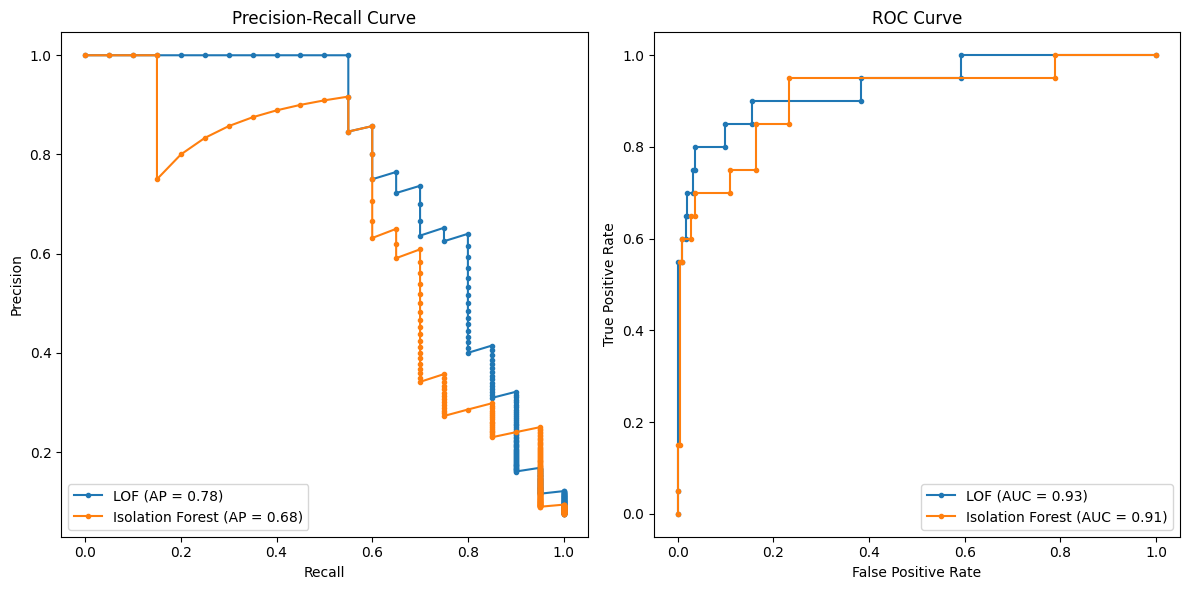

In [ ]:
import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']

# Define the image loading function
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

# Load and preprocess the images
img_list = [load_image(path, aligned=False) for path in path_list]

# Create labels (0 for 'good', 1 for 'anomaly')
labels = [0 if 'good' in path else 1 for path in experiment['train']]

# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.numpy().flatten() for img in img_list])
print(img_array.shape)
# LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_pred = lof.fit_predict(img_array)
lof_scores = -lof.negative_outlier_factor_

# Convert LOF output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
lof_pred = np.where(lof_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for LOF
lof_precision, lof_recall, _ = precision_recall_curve(labels, lof_scores)
lof_average_precision = average_precision_score(labels, lof_scores)

# Compute ROC curve and ROC AUC for LOF
lof_fpr, lof_tpr, _ = roc_curve(labels, lof_scores)
lof_roc_auc = auc(lof_fpr, lof_tpr)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
iso_forest.fit(img_array)
iso_scores = -iso_forest.decision_function(img_array)
iso_pred = iso_forest.predict(img_array)

# Convert Isolation Forest output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
iso_pred = np.where(iso_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for Isolation Forest
iso_precision, iso_recall, _ = precision_recall_curve(labels, iso_scores)
iso_average_precision = average_precision_score(labels, iso_scores)

# Compute ROC curve and ROC AUC for Isolation Forest
iso_fpr, iso_tpr, _ = roc_curve(labels, iso_scores)
iso_roc_auc = auc(iso_fpr, iso_tpr)

# Plot the precision-recall curve and ROC curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Precision-Recall curve
ax1.plot(lof_recall, lof_precision, marker='.', label=f'LOF (AP = {lof_average_precision:.2f})')
ax1.plot(iso_recall, iso_precision, marker='.', label=f'Isolation Forest (AP = {iso_average_precision:.2f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# ROC curve
ax2.plot(lof_fpr, lof_tpr, marker='.', label=f'LOF (AUC = {lof_roc_auc:.2f})')
ax2.plot(iso_fpr, iso_tpr, marker='.', label=f'Isolation Forest (AUC = {iso_roc_auc:.2f})')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


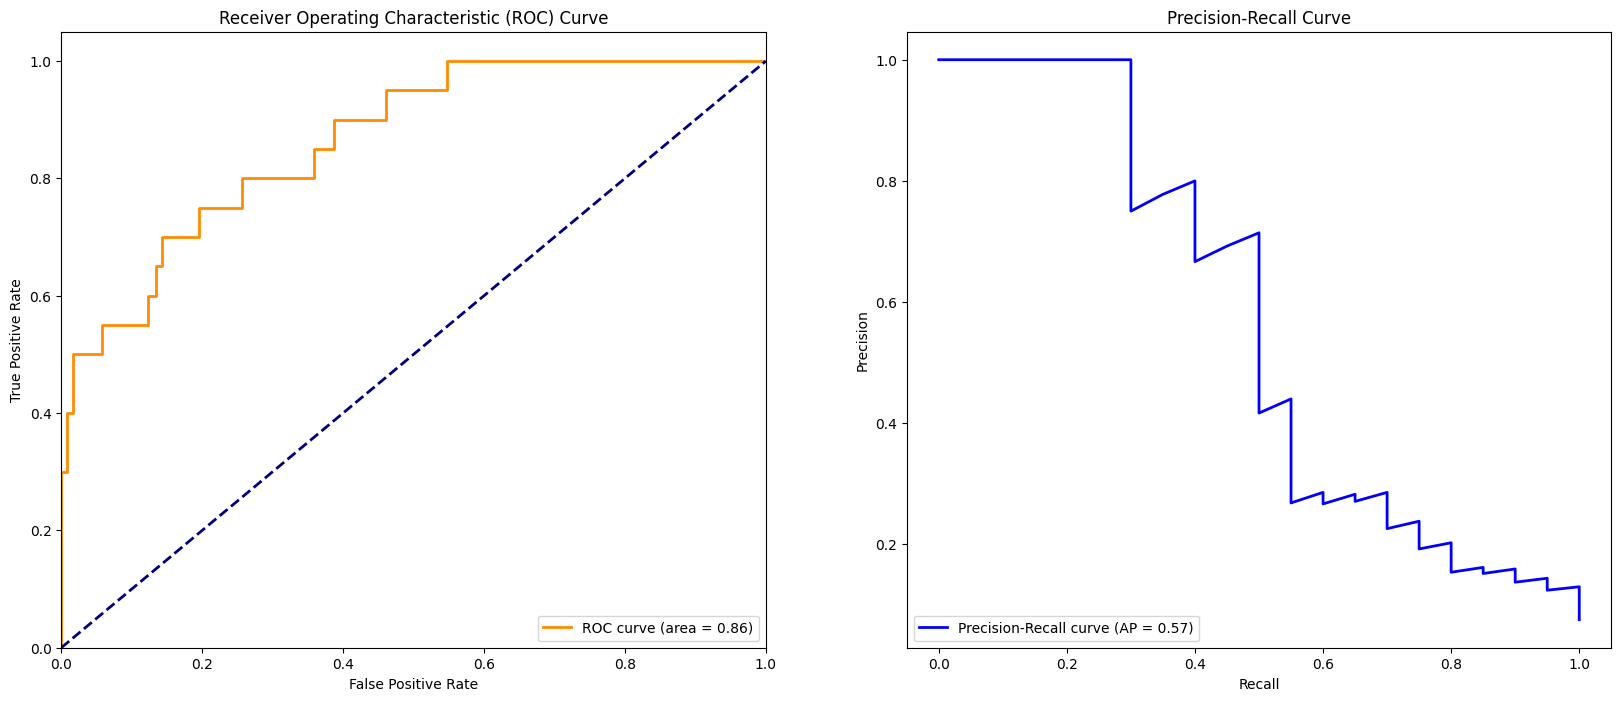

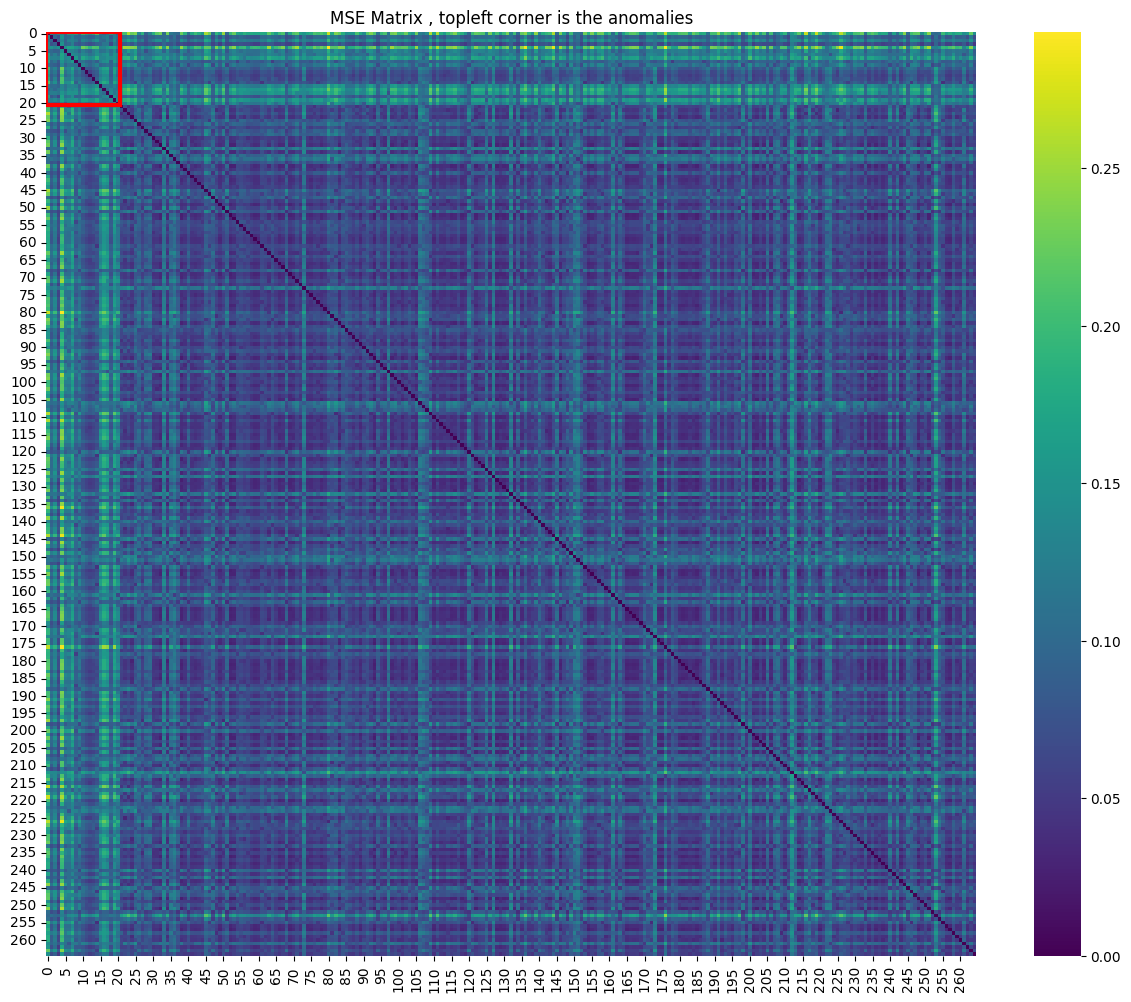

In [ ]:
################ Only MSE

import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']

# Define the image loading function
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

# Load and preprocess the images
img_list = [load_image(path, aligned=False) for path in path_list]

# Function to compute MSE between two images
def compute_mse(img1, img2):
    return mean_squared_error(img1.numpy().flatten(), img2.numpy().flatten())

# Create an empty matrix to store MSE values
mse_matrix = np.zeros((len(img_list), len(img_list)))

# Calculate the MSE between each pair of images
for i in range(len(img_list)):
    for j in range(len(img_list)):
        mse_matrix[i, j] = compute_mse(img_list[i], img_list[j])


# Get true labels
labels = np.array([0 if 'good' in path else 1 for path in experiment['train']])

# Calculate column sums of the MSE matrix
col_sums = np.sum(mse_matrix, axis=0)

# Sort the column sums and labels
indexes = np.argsort(col_sums)
colsums_sorted = col_sums[indexes]
labels_sorted = labels[indexes]

# Normalize the sorted column sums
scaler = MinMaxScaler()
colsums_sorted = scaler.fit_transform(colsums_sorted.reshape(-1, 1)).flatten()

# Calculate precision, recall, and ROC AUC
precision, recall, _ = precision_recall_curve(labels_sorted, colsums_sorted)
average_precision = average_precision_score(labels_sorted, colsums_sorted)
fpr, tpr, _ = roc_curve(labels_sorted, colsums_sorted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and Precision-Recall curve side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc="lower left")

plt.show()

indexes_1 = np.where(labels == 1)[0]
indexes_0 = np.where(labels == 0)[0]
index_conc=np.concatenate((indexes_1,indexes_0))
index_conc



img_list_reorder=[img_list[i] for i in index_conc]
# Create an empty matrix to store MSE values
mse_matrix_2 = np.zeros((len(img_list_reorder), len(img_list_reorder)))

# Calculate the MSE between each pair of images
for i in range(len(img_list_reorder)):
    for j in range(len(img_list_reorder)):
        mse_matrix_2[i, j] = compute_mse(img_list_reorder[i], img_list_reorder[j])


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches


# Create a heatmap
plt.figure(figsize=(15, 12))
ax = sns.heatmap(mse_matrix_2, cmap="viridis")

# Add a square frame to the top-left corner
rect = patches.Rectangle((0, 0), 21, 21, linewidth=3, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# Set the title and labels for the axes
plt.title("MSE Matrix , topleft corner is the anomalies")
plt.show()


In [ ]:
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']


def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
featuremaps = []
backbone = models.resnet18(pretrained=True).to(device)
backbone.eval()
outputs = []

def hook(module, input, output):
    outputs.append(output)

backbone.layer1[-1].register_forward_hook(hook)
backbone.layer2[-1].register_forward_hook(hook)
backbone.layer3[-1].register_forward_hook(hook)

img_list = [load_image(path, aligned=False) for path in path_list]

with torch.no_grad():
    for img in img_list:
        img = img.unsqueeze(0).to(device)
        outputs = []
        _ = backbone(img)
        outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
        featuremaps.append(outputs.cpu().numpy())


shuffled_final = np.array(featuremaps).squeeze()







/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.flatten() for img in shuffled_final])
img_array.shape

(265, 1835008)

In [ ]:
# LOF
img_array = np.array([img.flatten() for img in shuffled_final])
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_pred = lof.fit_predict(img_array)
lof_scores = -lof.negative_outlier_factor_

# Convert LOF output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
lof_pred = np.where(lof_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for LOF
lof_precision, lof_recall, _ = precision_recall_curve(labels, lof_scores)
lof_average_precision = average_precision_score(labels, lof_scores)

# Compute ROC curve and ROC AUC for LOF
lof_fpr, lof_tpr, _ = roc_curve(labels, lof_scores)
lof_roc_auc = auc(lof_fpr, lof_tpr)

# # Isolation Forest
# iso_forest = IsolationForest(contamination=0.1, random_state=args.seed)
# iso_forest.fit(img_array)
# iso_scores = -iso_forest.decision_function(img_array)
# iso_pred = iso_forest.predict(img_array)

# # Convert Isolation Forest output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
# iso_pred = np.where(iso_pred == -1, 1, 0)

# # Compute precision-recall curve and average precision score for Isolation Forest
# iso_precision, iso_recall, _ = precision_recall_curve(labels, iso_scores)
# iso_average_precision = average_precision_score(labels, iso_scores)

# # Compute ROC curve and ROC AUC for Isolation Forest
# iso_fpr, iso_tpr, _ = roc_curve(labels, iso_scores)
# iso_roc_auc = auc(iso_fpr, iso_tpr)

# Plot the precision-recall curve and ROC curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Precision-Recall curve
ax1.plot(lof_recall, lof_precision, marker='.', label=f'LOF (AP = {lof_average_precision:.2f})')
ax1.plot(iso_recall, iso_precision, marker='.', label=f'Isolation Forest (AP = {iso_average_precision:.2f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# # ROC curve
# ax2.plot(lof_fpr, lof_tpr, marker='.', label=f'LOF (AUC = {lof_roc_auc:.2f})')
# ax2.plot(iso_fpr, iso_tpr, marker='.', label=f'Isolation Forest (AUC = {iso_roc_auc:.2f})')
# ax2.set_xlabel('False Positive Rate')
# ax2.set_ylabel('True Positive Rate')
# ax2.set_title('ROC Curve')
# ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

: 

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


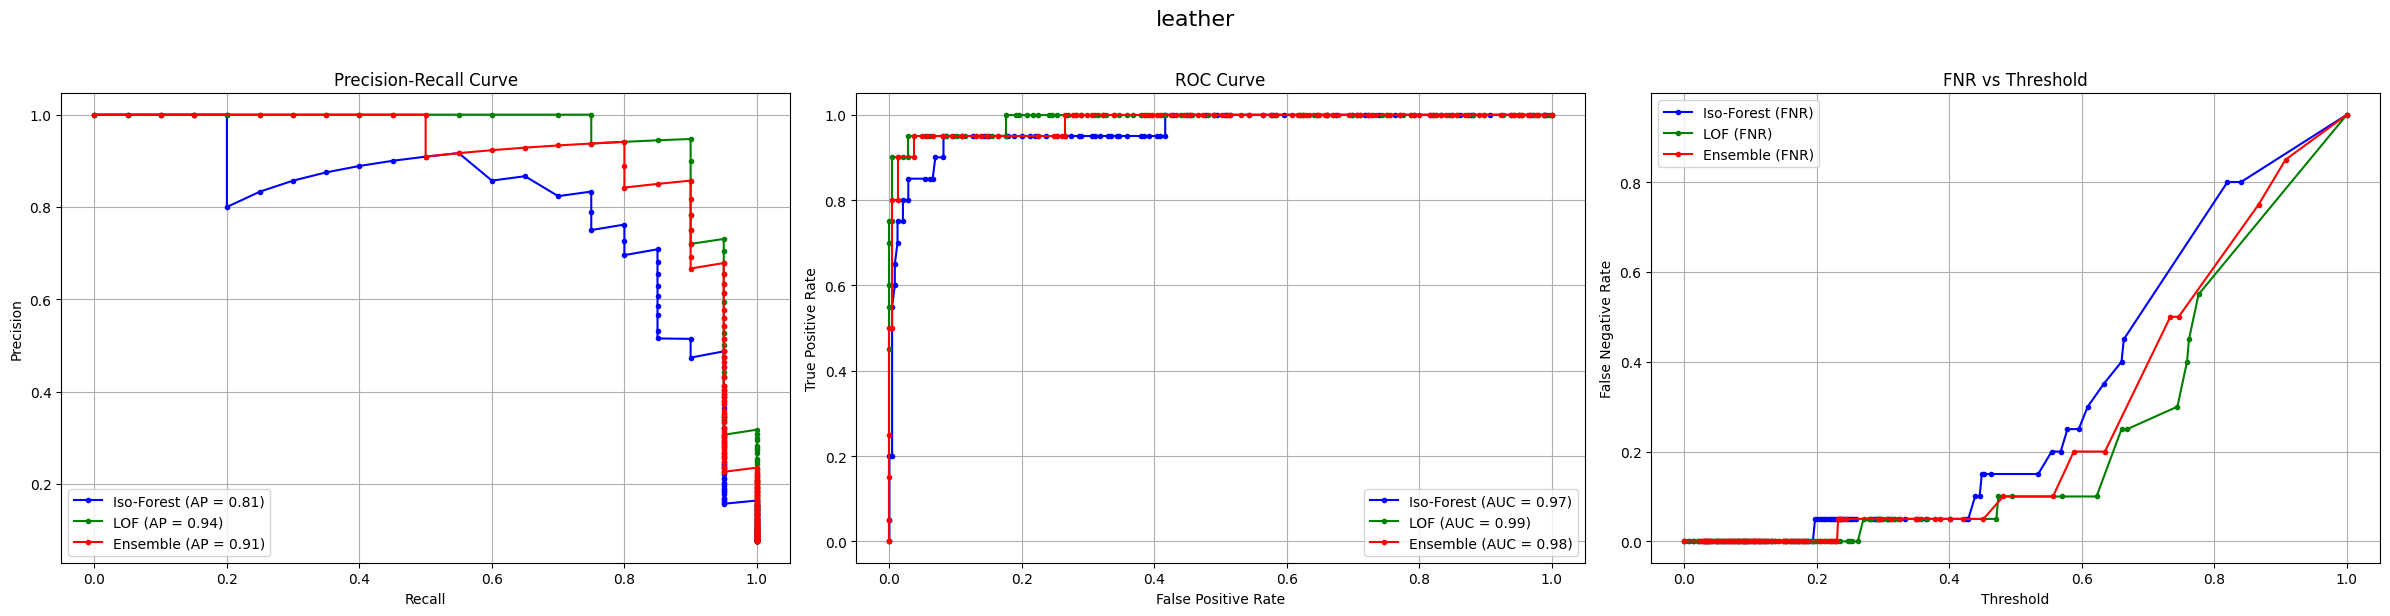

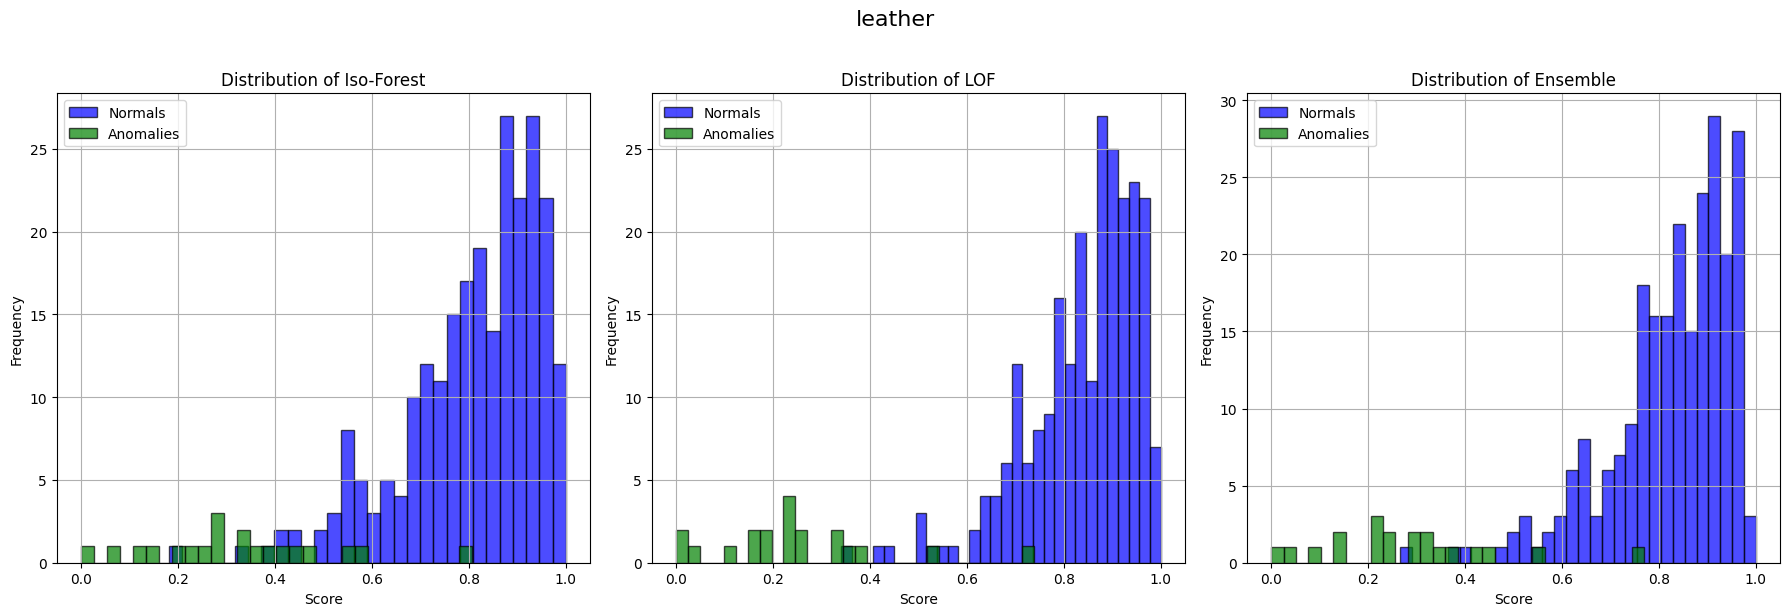

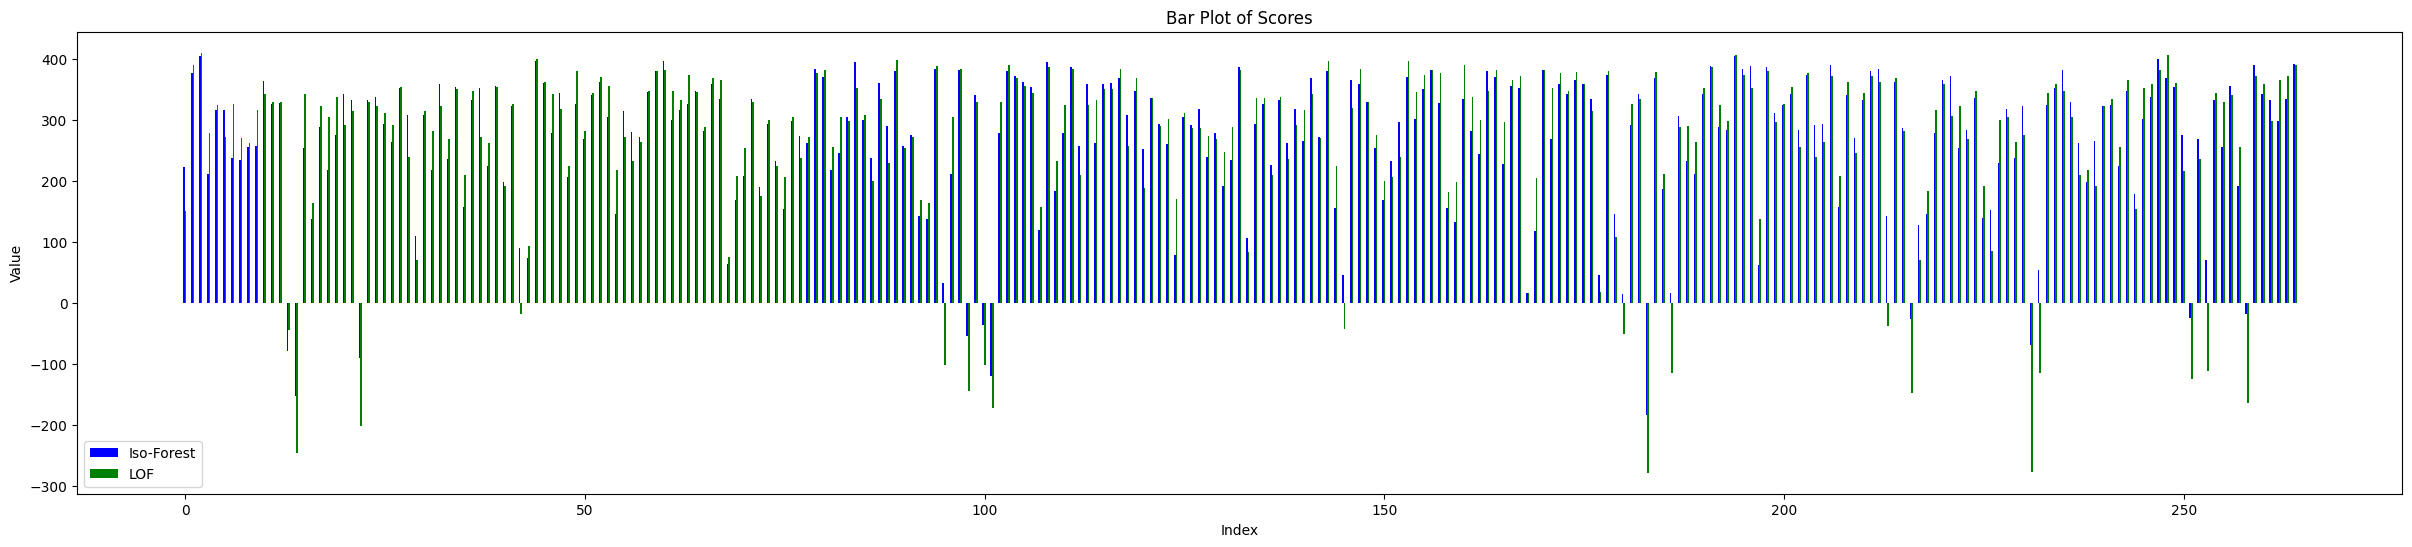

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


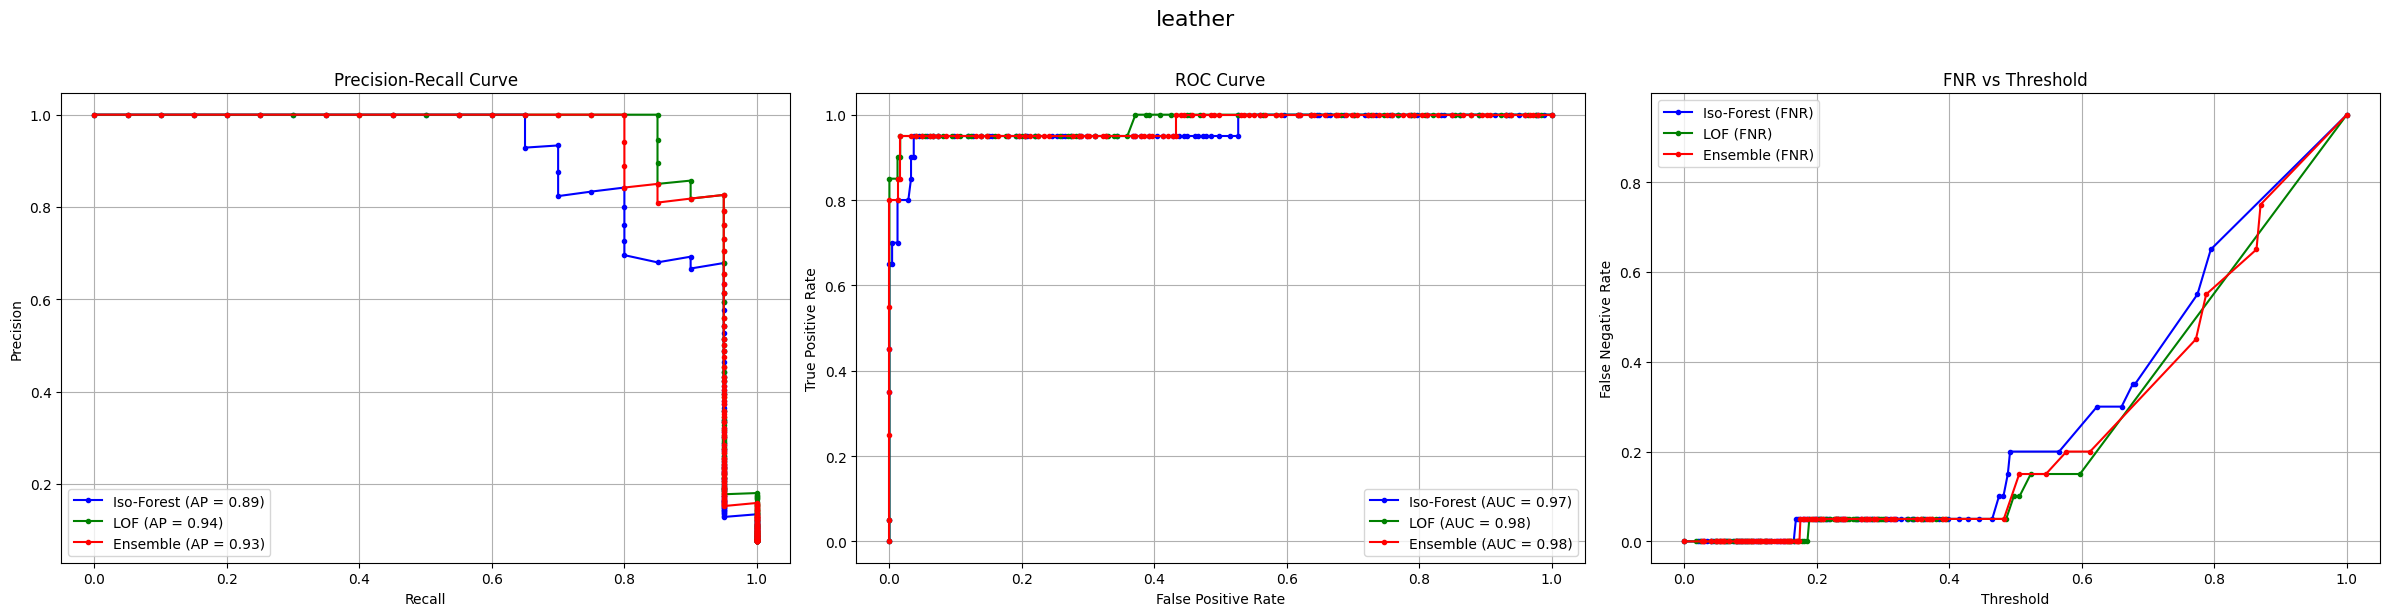

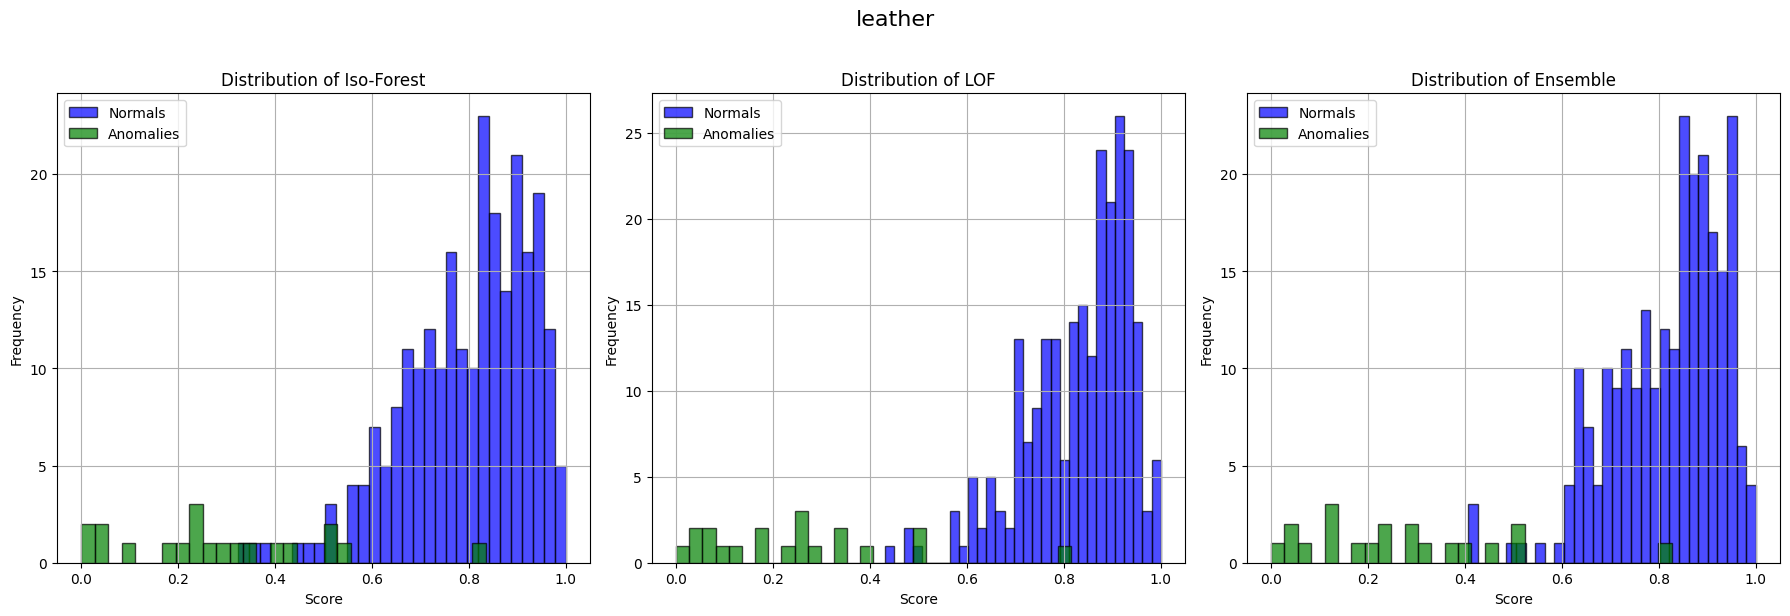

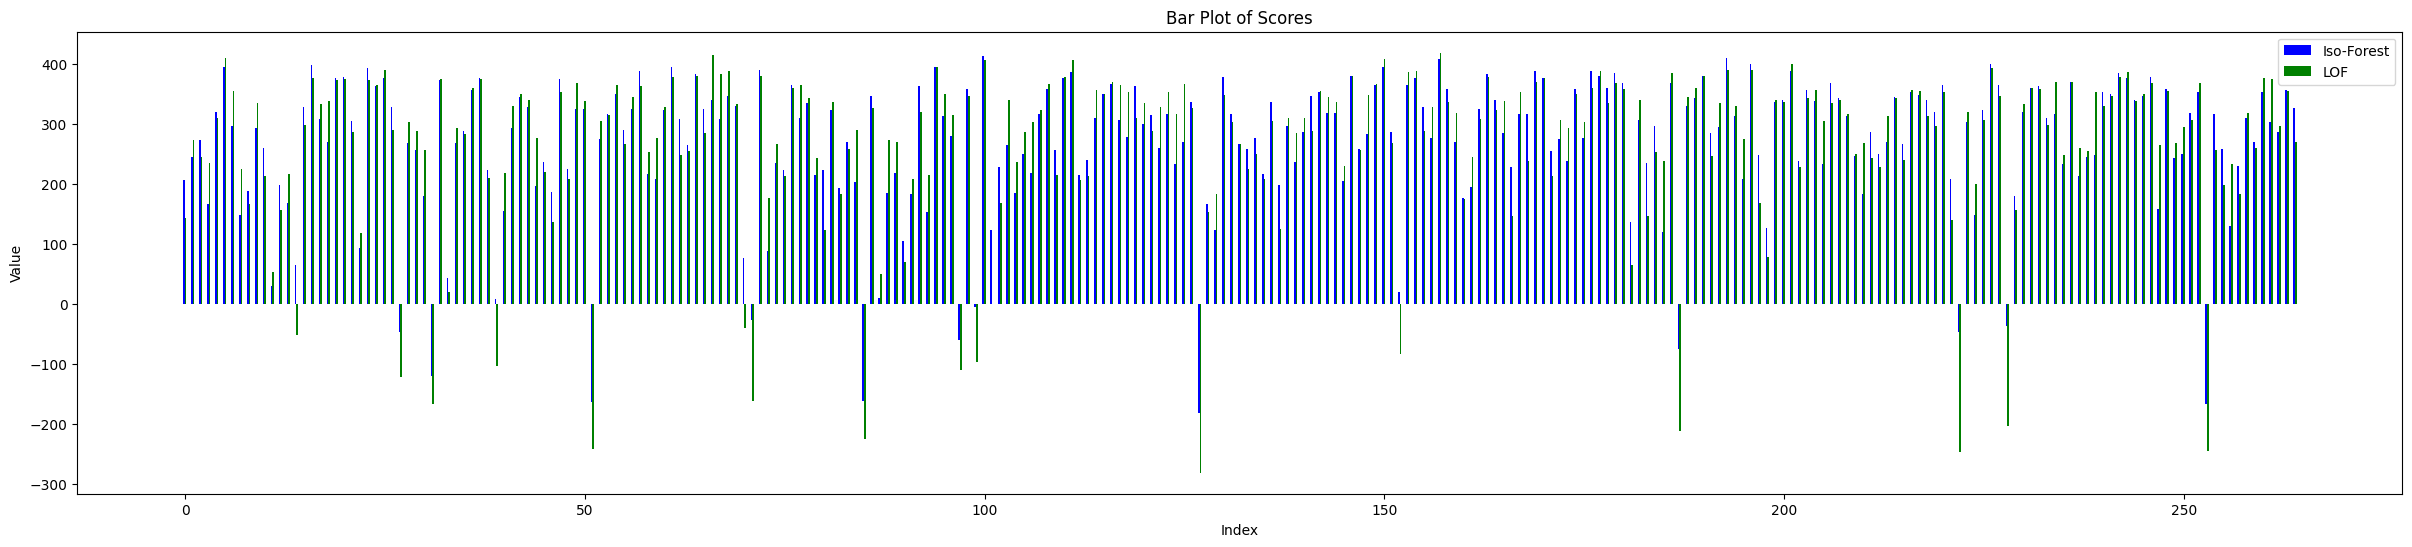

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


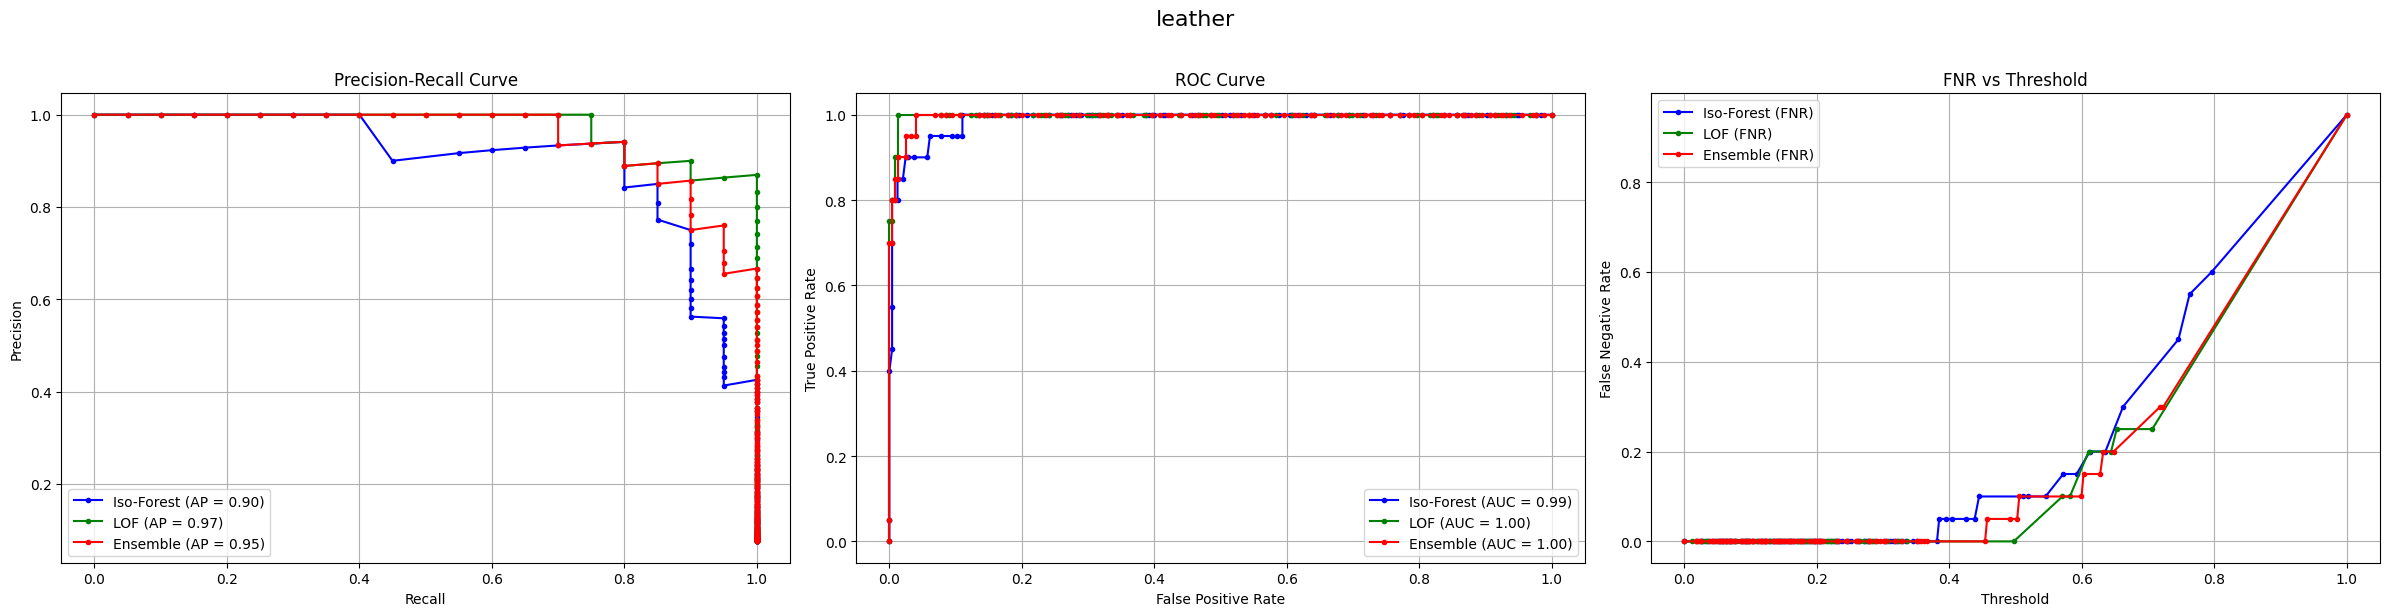

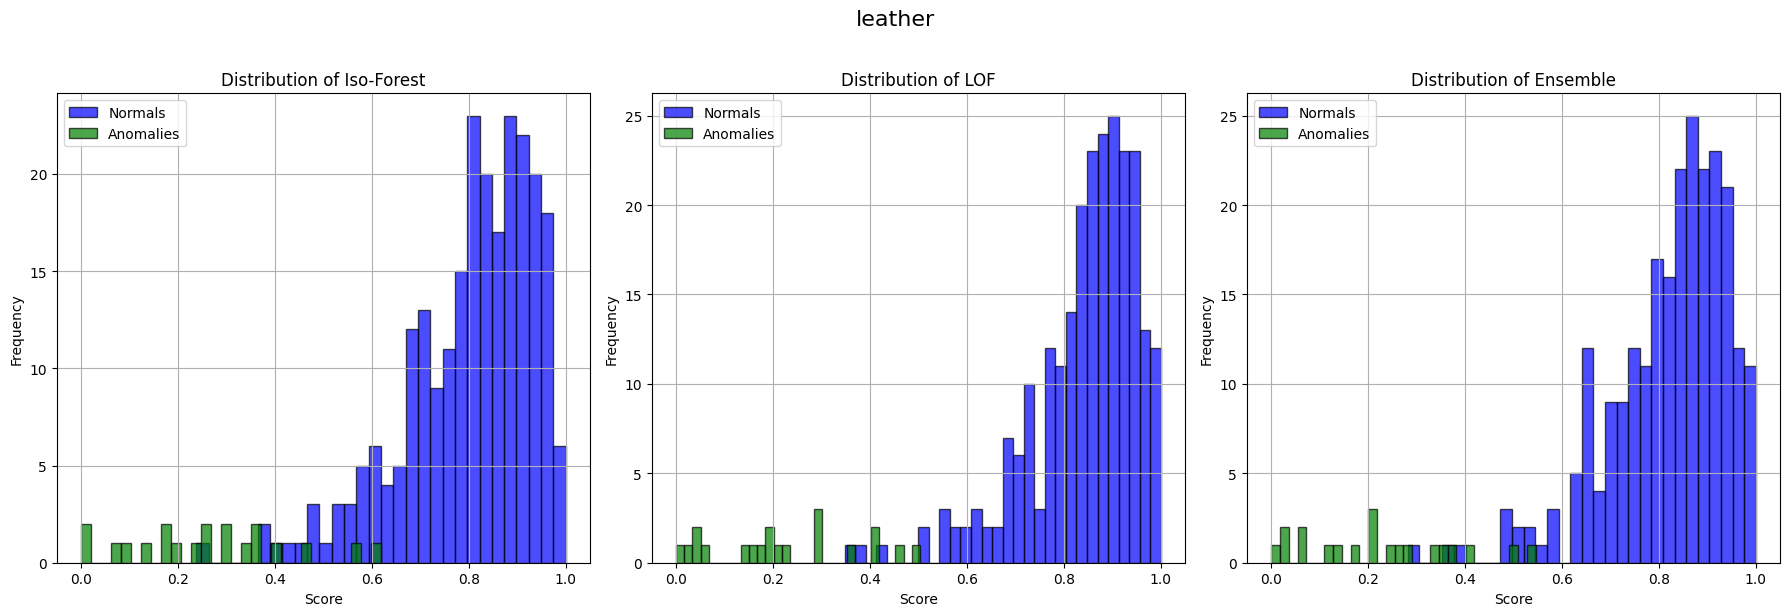

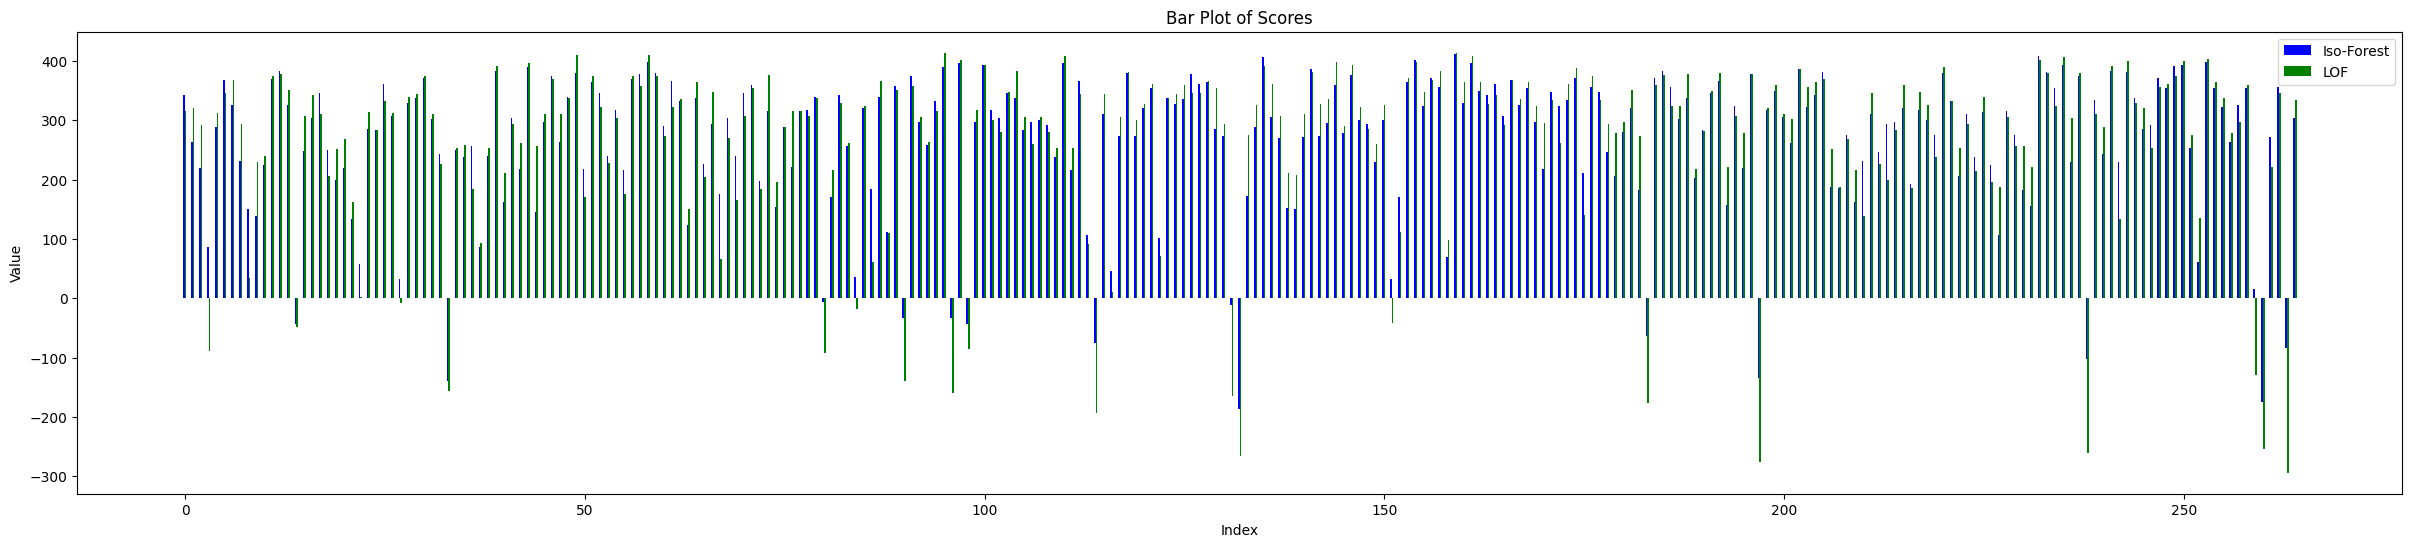

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


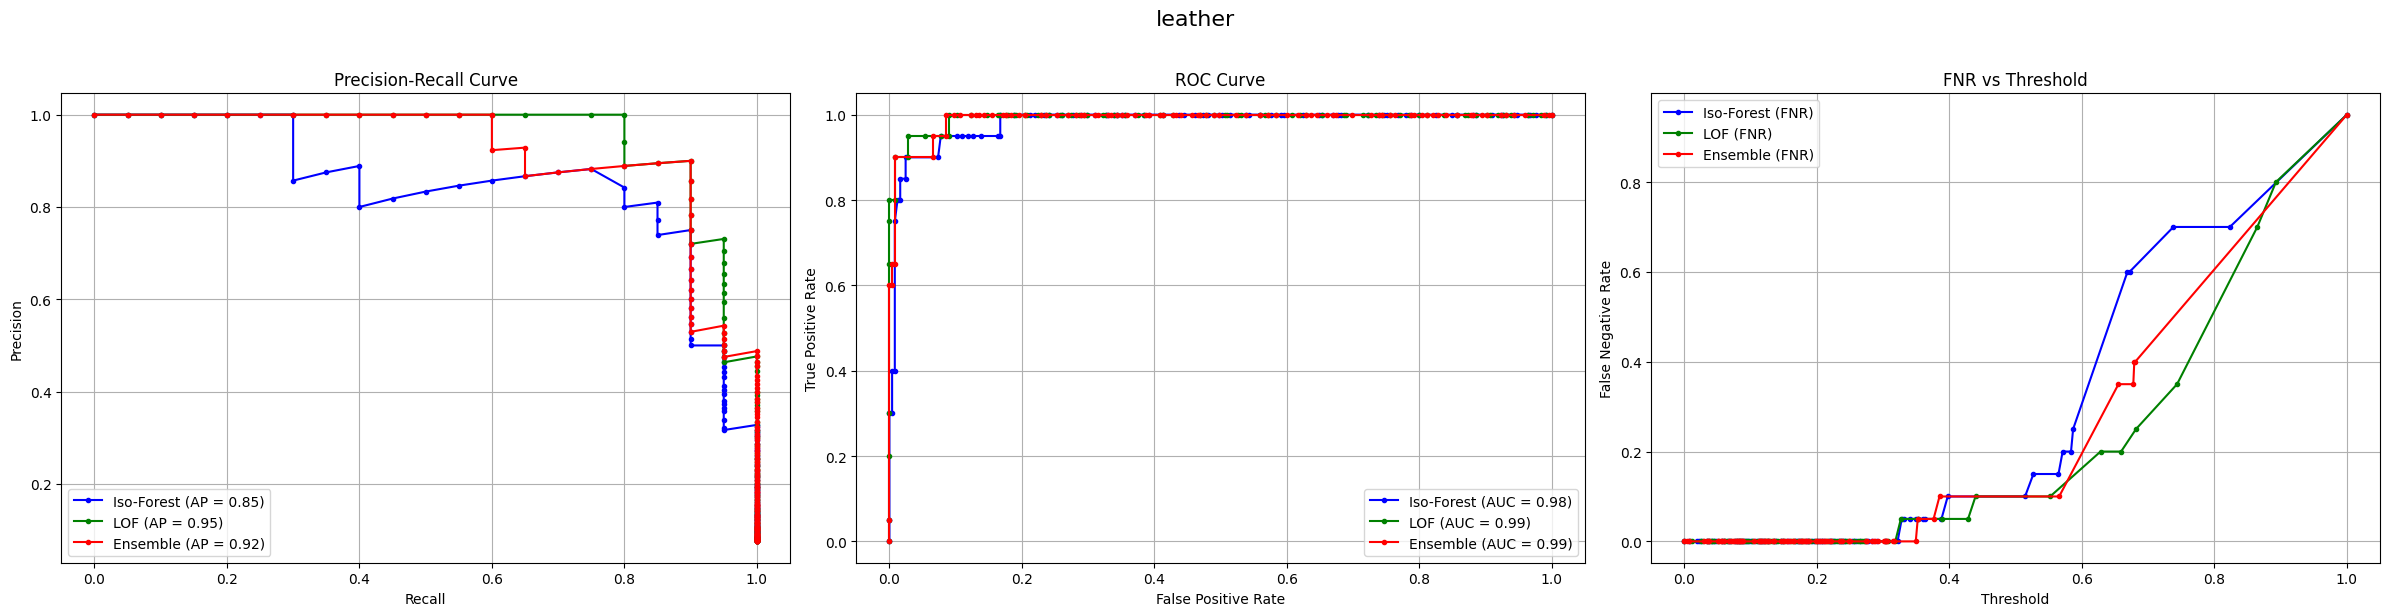

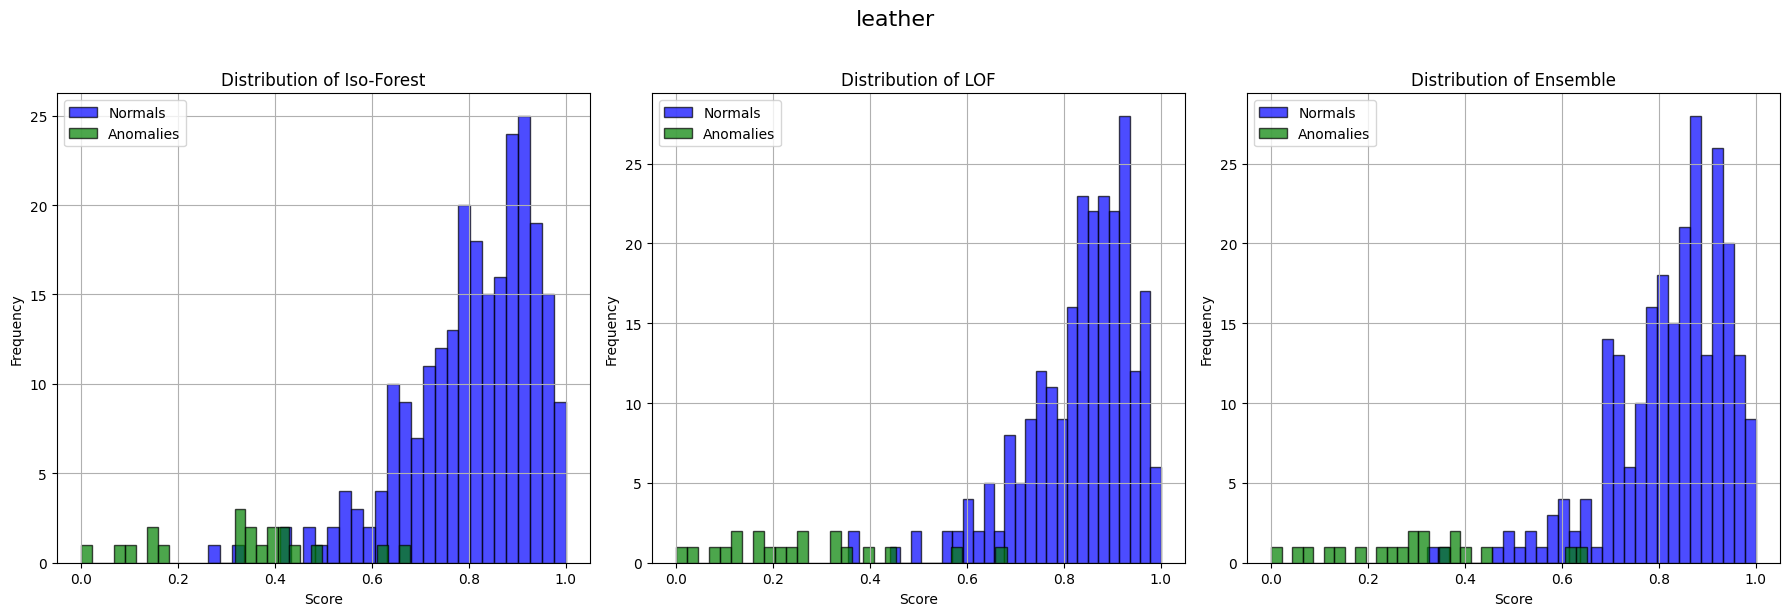

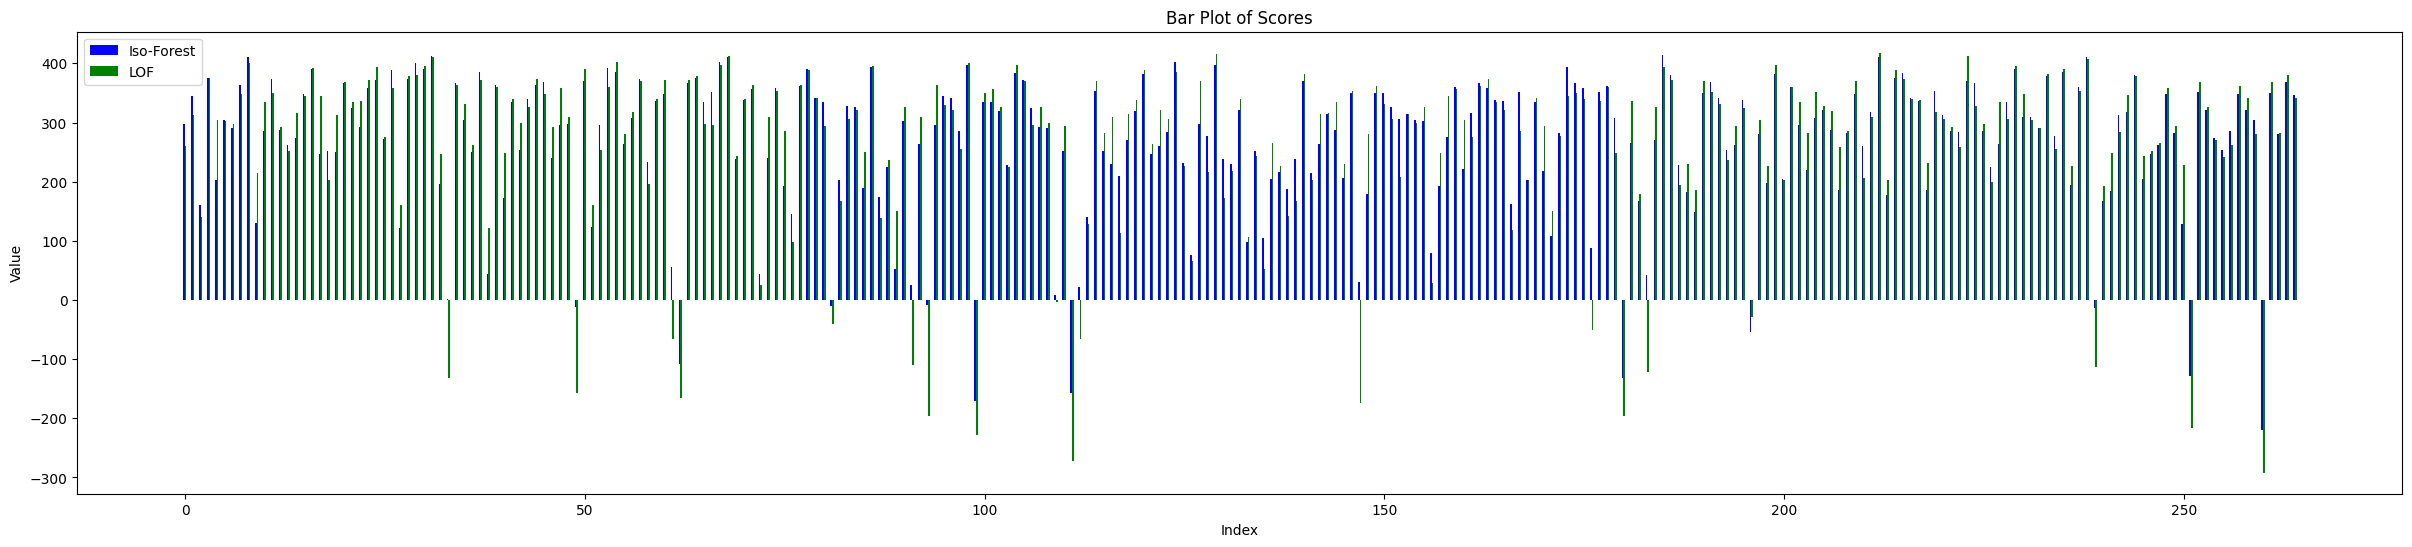

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


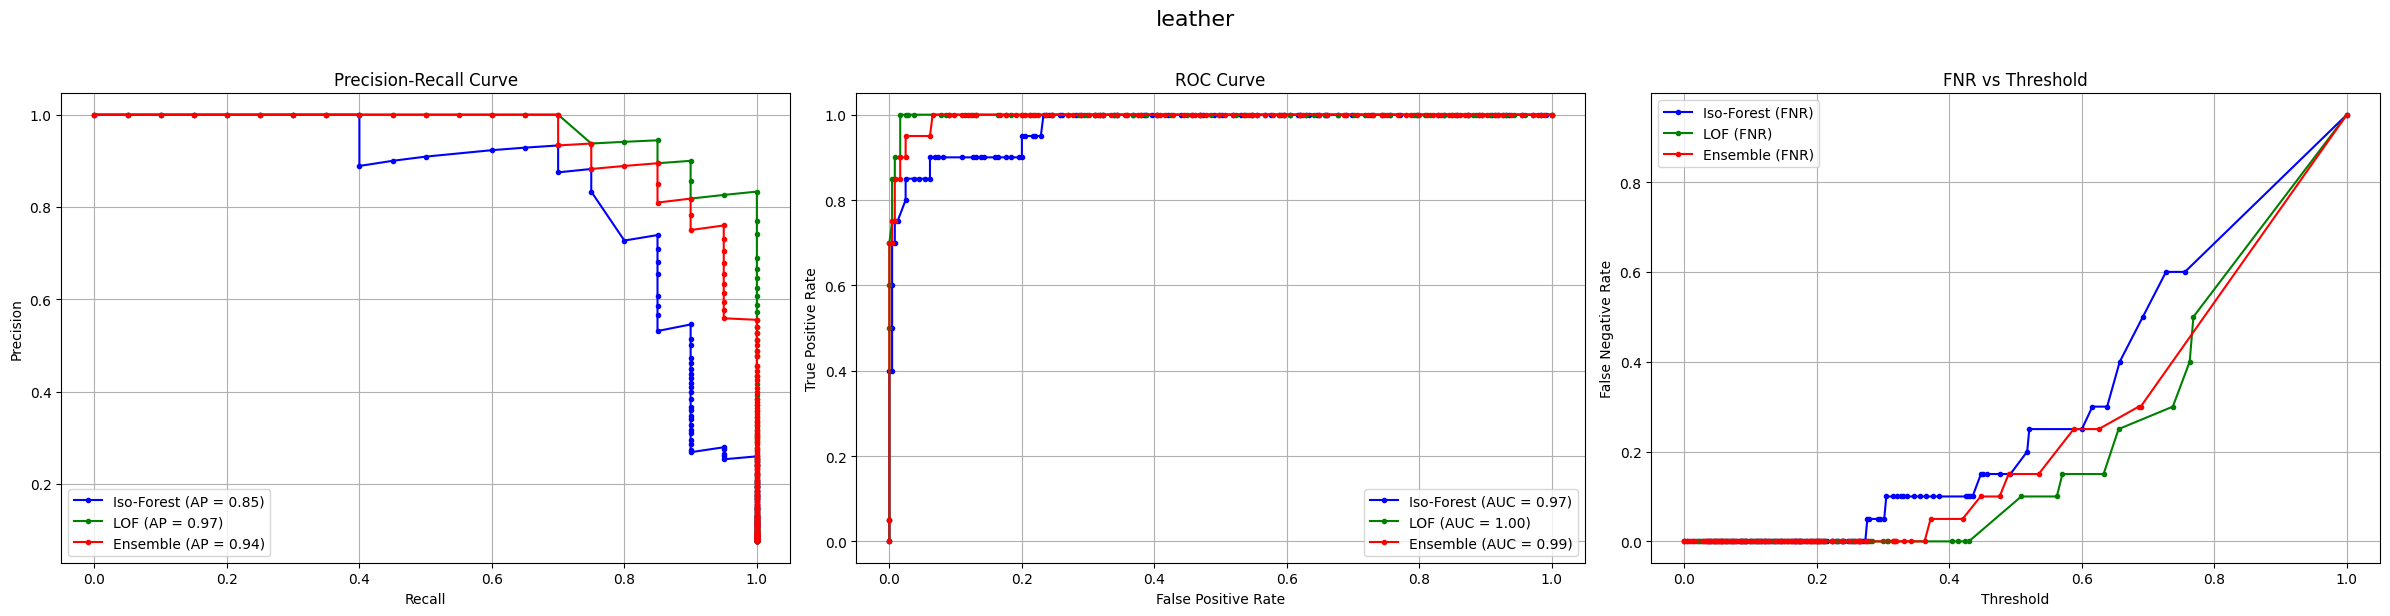

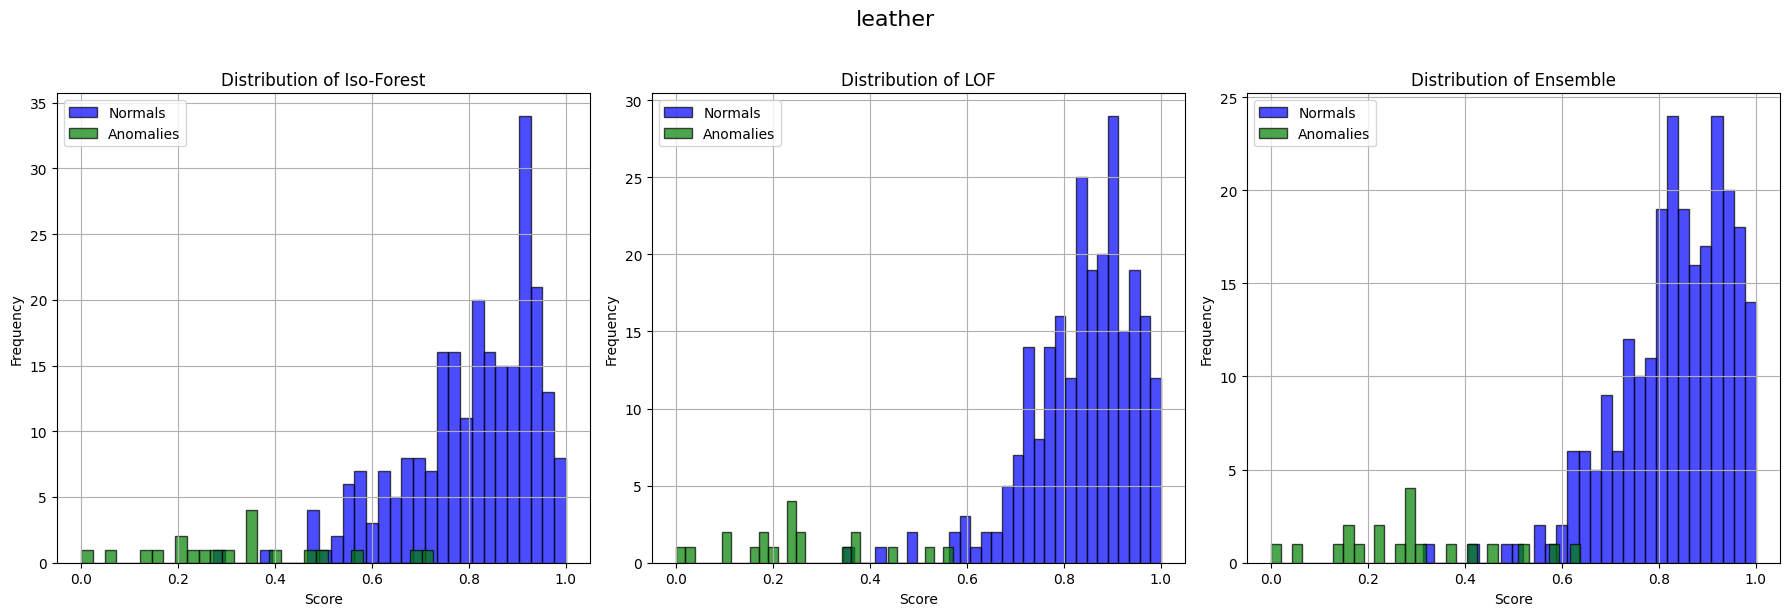

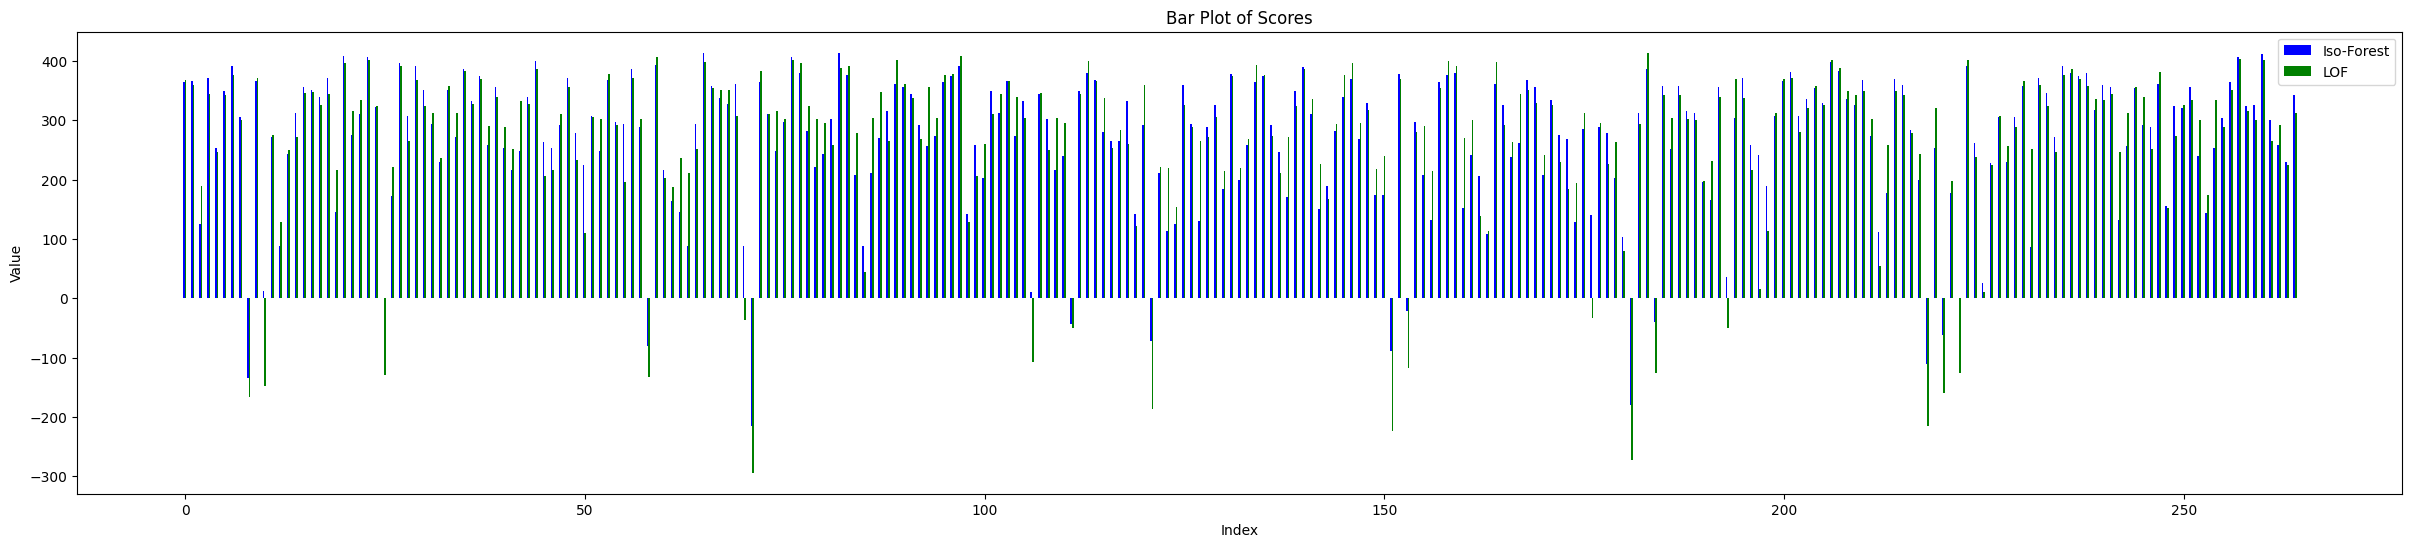

In [ ]:
category= "leather"

class TrainOptions:
    def __init__(self):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

args = TrainOptions()
torch.manual_seed(args.seed)





#run1
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run2
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_2-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run3
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_3-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run4
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_4-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run5
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_5-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)



# CARPET

In [ ]:
category= "carpet"

class TrainOptions:
    def __init__(self):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

args = TrainOptions()
torch.manual_seed(args.seed)





#run1
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run2
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_2-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run3
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_3-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run4
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_4-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

# run5
experiment_path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_5-carpet/experiment_paths.json'
with open(experiment_path, 'r') as file:
     experiment = json.load(file)

experiment=refine_paths(experiment,args) 
labels=[0 if 'good' in path else 1 for path in experiment['train']]
metrics_and_plots(np.array(labels),  np.array(experiment['isoforest_scores']),np.array(experiment['lof_scores']), np.array(experiment['isoforest_scores'])+np.array(experiment['lof_scores']), category)

